Bibliotecas importadas correctamente para modelo LSTM mejorado.
Directorio 'modelos_lstm' creado correctamente.
Cargando datos...
Datos cargados correctamente: 662 registros, 74 columnas

Primeras 3 filas del dataset:
        Jugador  Temporada      Fecha   Equipo   Oponente  Goles  Asistencias Día de la semana  Sede Titular  Minutos  Penales marcados  Penales intentados  Tiros totales  Tiros a puerta  Tarjetas amarillas  Tarjetas rojas  Faltas cometidas  Faltas recibidas  Fuera de juego  Centros  Entradas ganadas  Intercepciones  Goles en propia  Penales ganados  Penales concedidos   Año  Mes Equipo_Estandarizado  Equipo_Es_Colombiano Equipo_Bucaramanga Equipo_Independiente Santa Fe Equipo_Junior Equipo_Millonarios Equipo_Once Caldas Equipo_Pereira Equipo_Rionegro Oponente_Estandarizado  Oponente_Es_Colombiano Oponente_Alianza FC Oponente_Atlético Huila Oponente_Atlético Nacional Oponente_Boyacá Chicó Oponente_Bucaramanga Oponente_Cortuluá Oponente_Deportes Tolima Oponente_Deportivo C

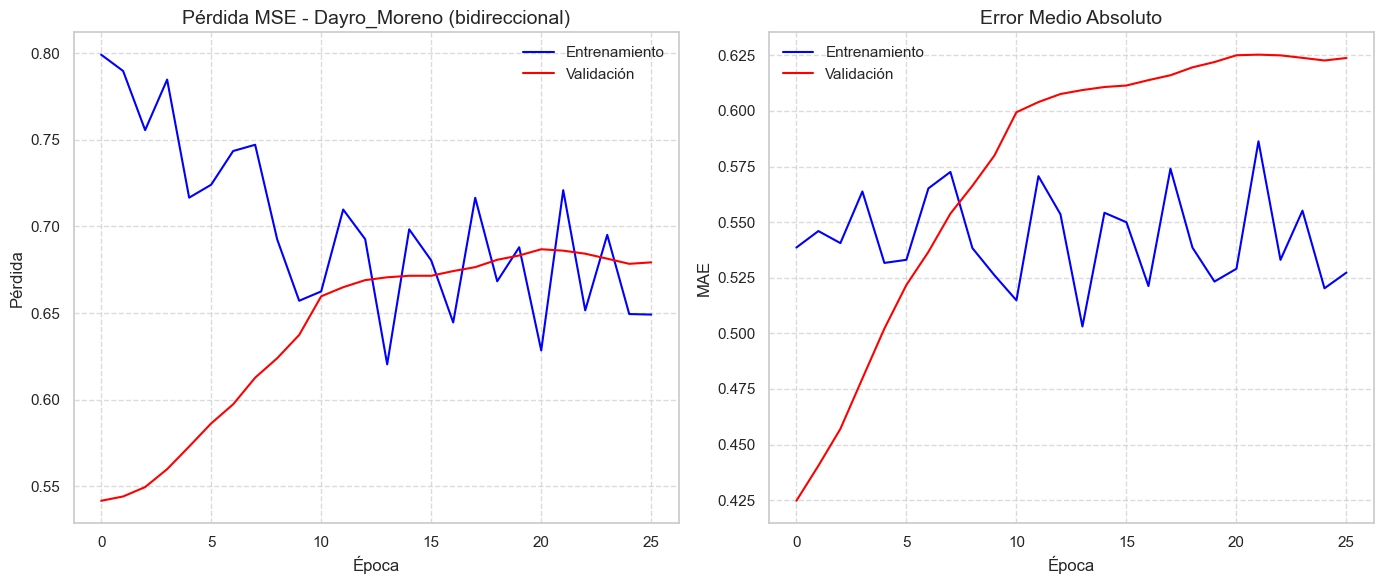

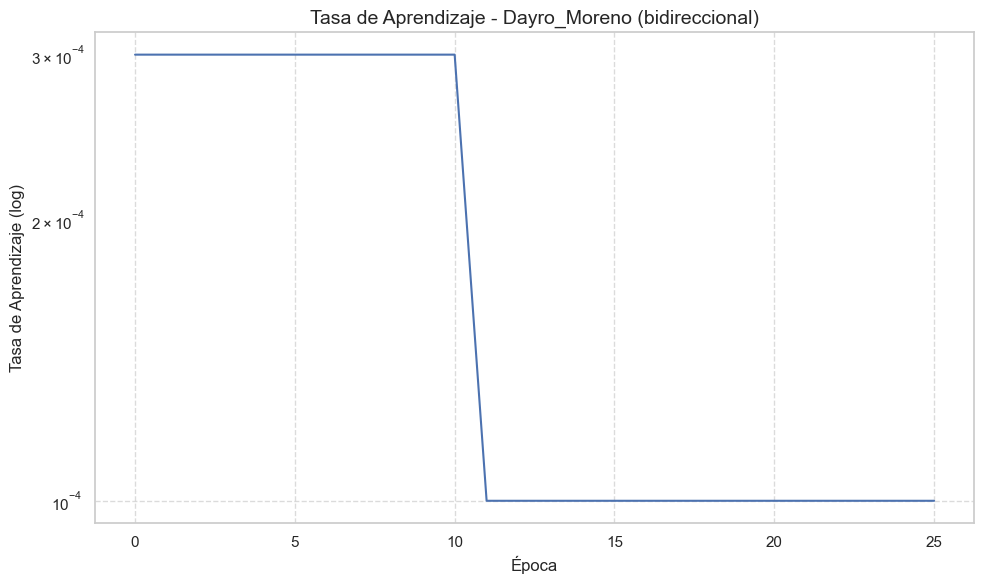

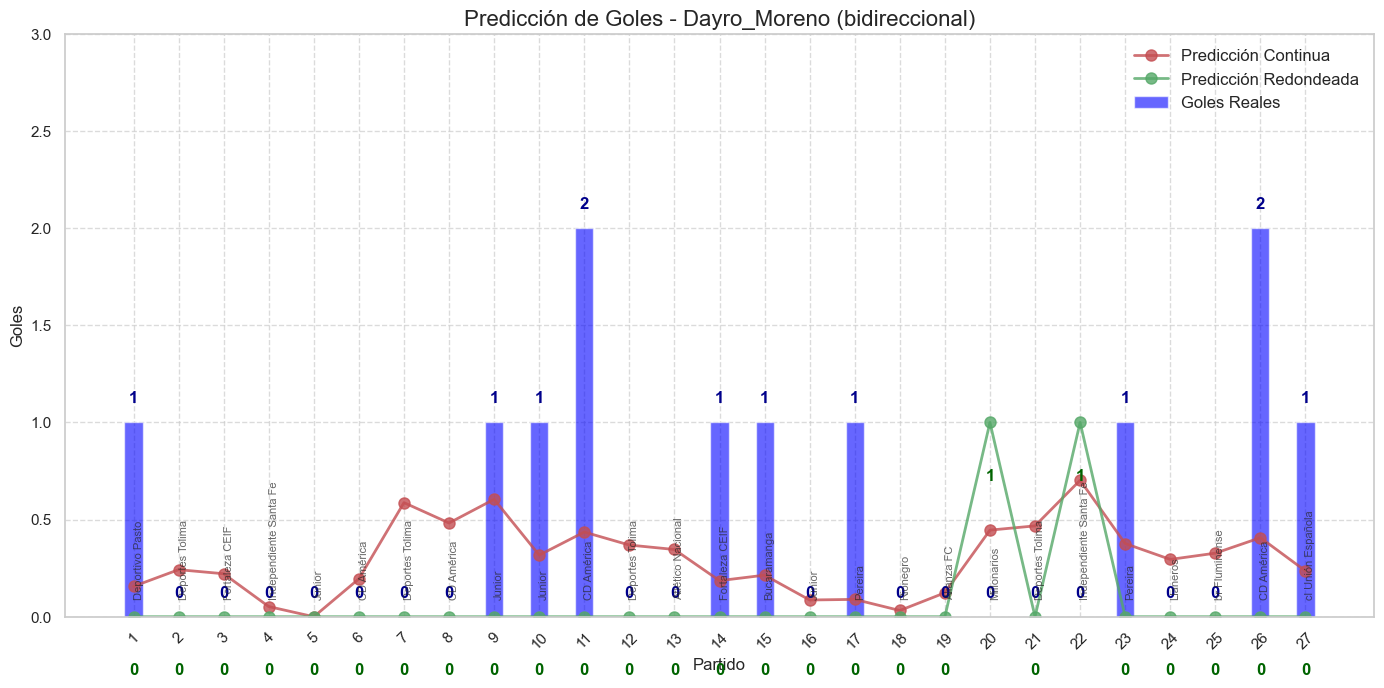

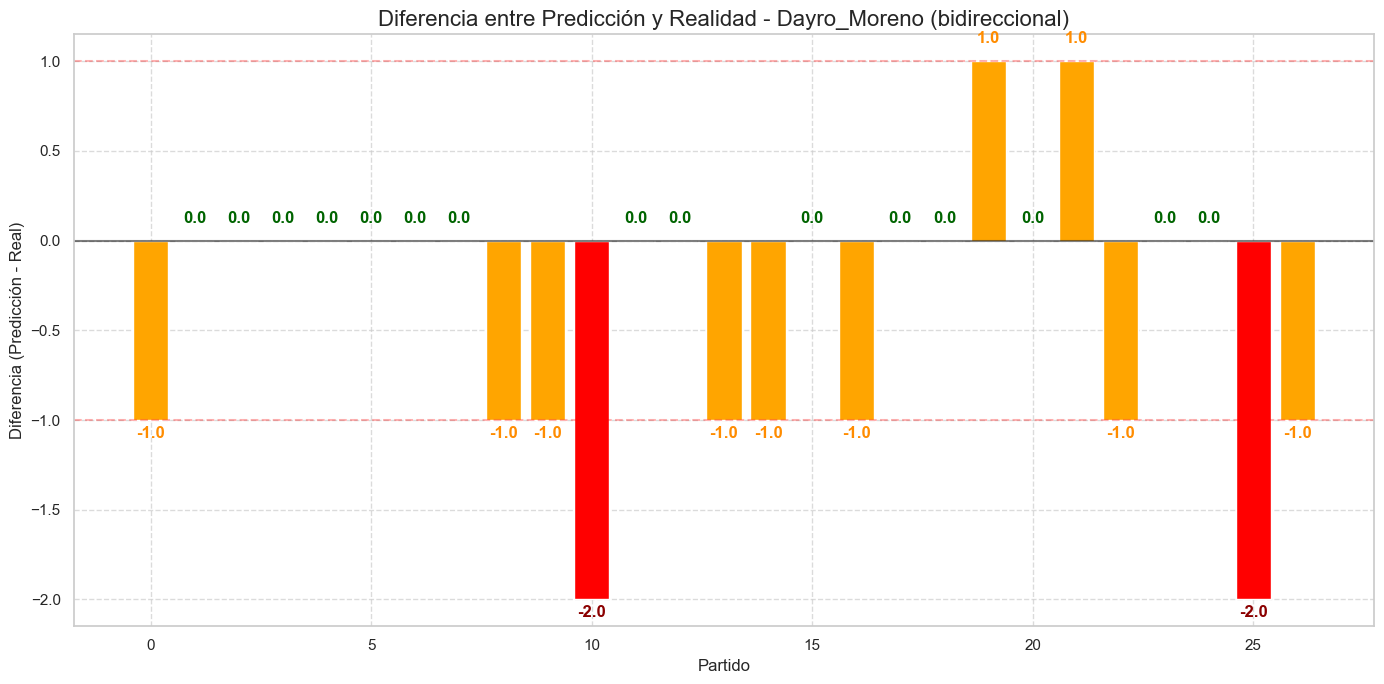

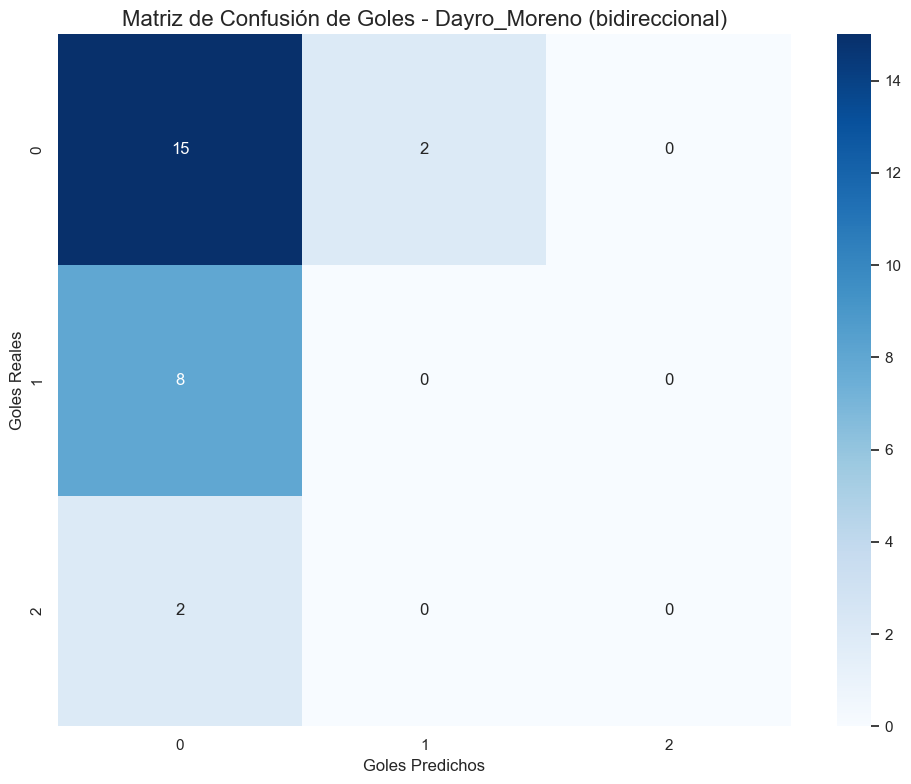

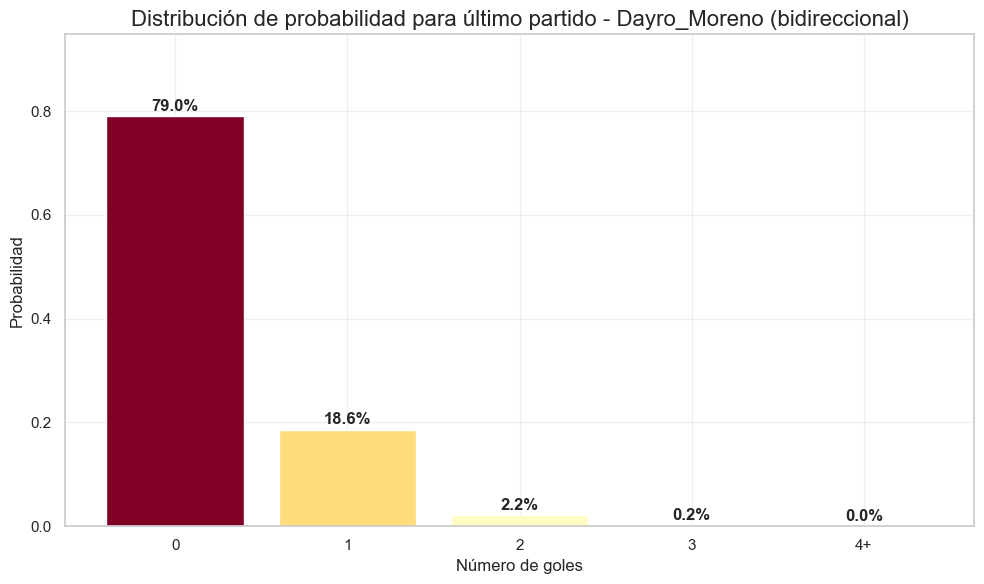


Predicciones para partidos futuros de Dayro_Moreno:
Modelo LSTM (bidireccional) cargado para Dayro_Moreno
Equipo actual de Dayro_Moreno: Once Caldas
Encontrados 20 partidos futuros para Once Caldas
Característica 'Factor_Oponente' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_5' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Marco_Ultimo_Partido' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Ult_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Tendencia_Robusta' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Es_FinDeSemana' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Racha_Con_Gol' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_7' no encontrada en 

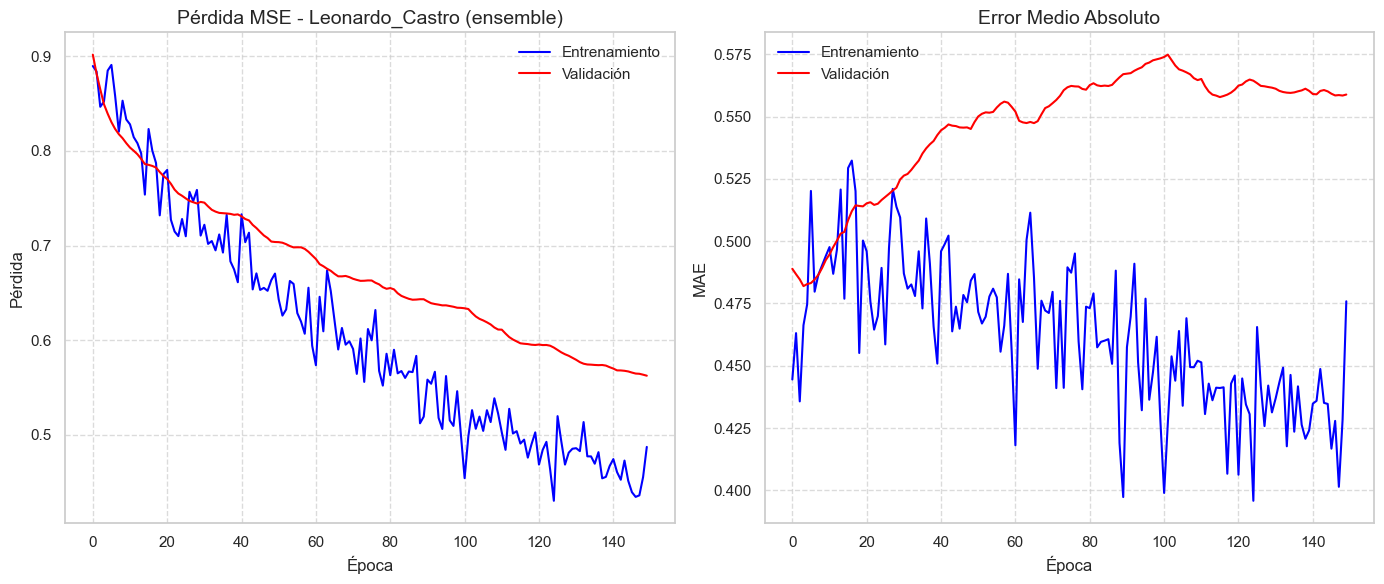

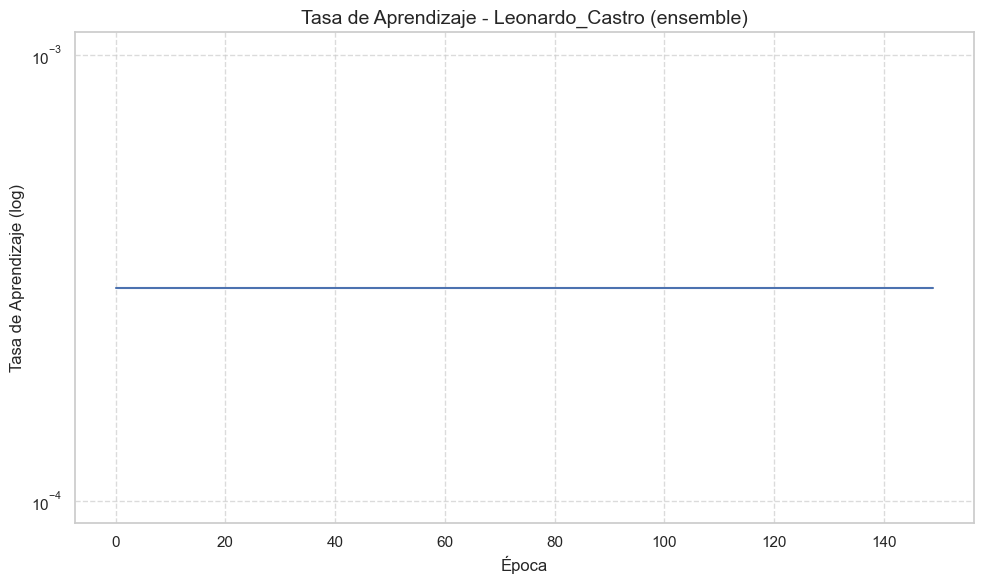

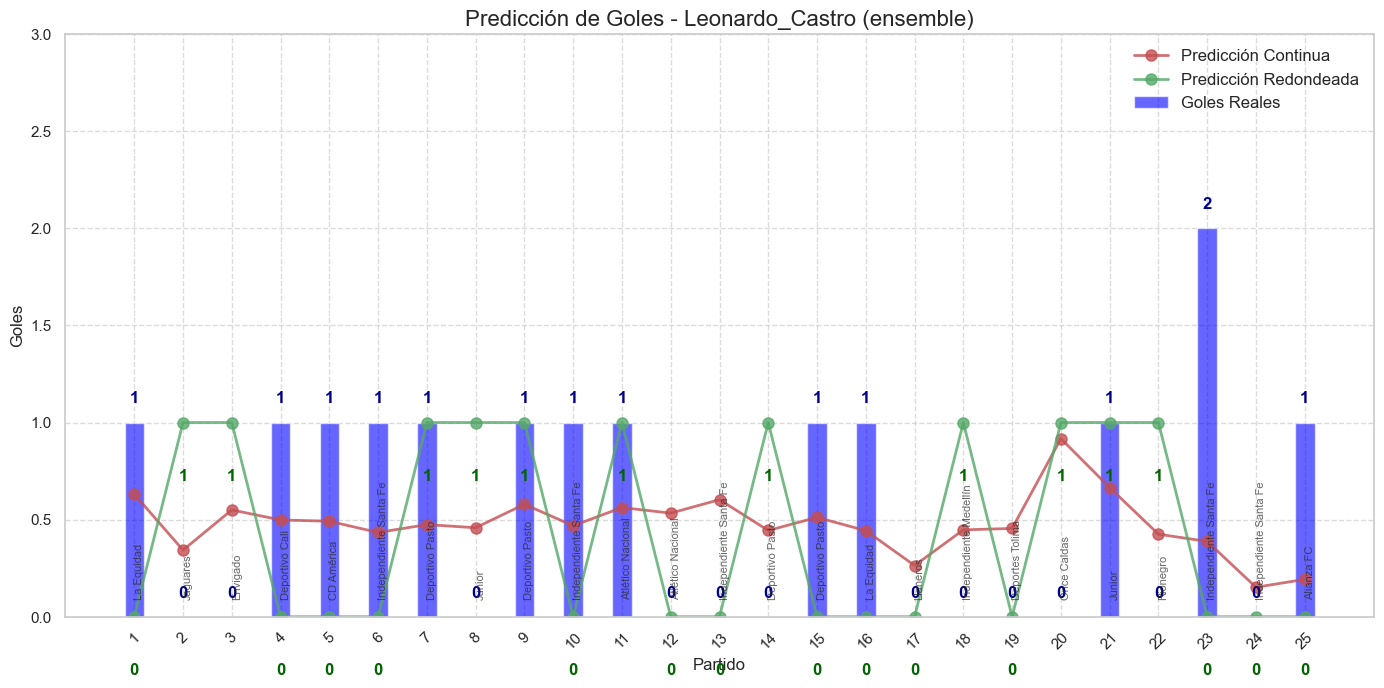

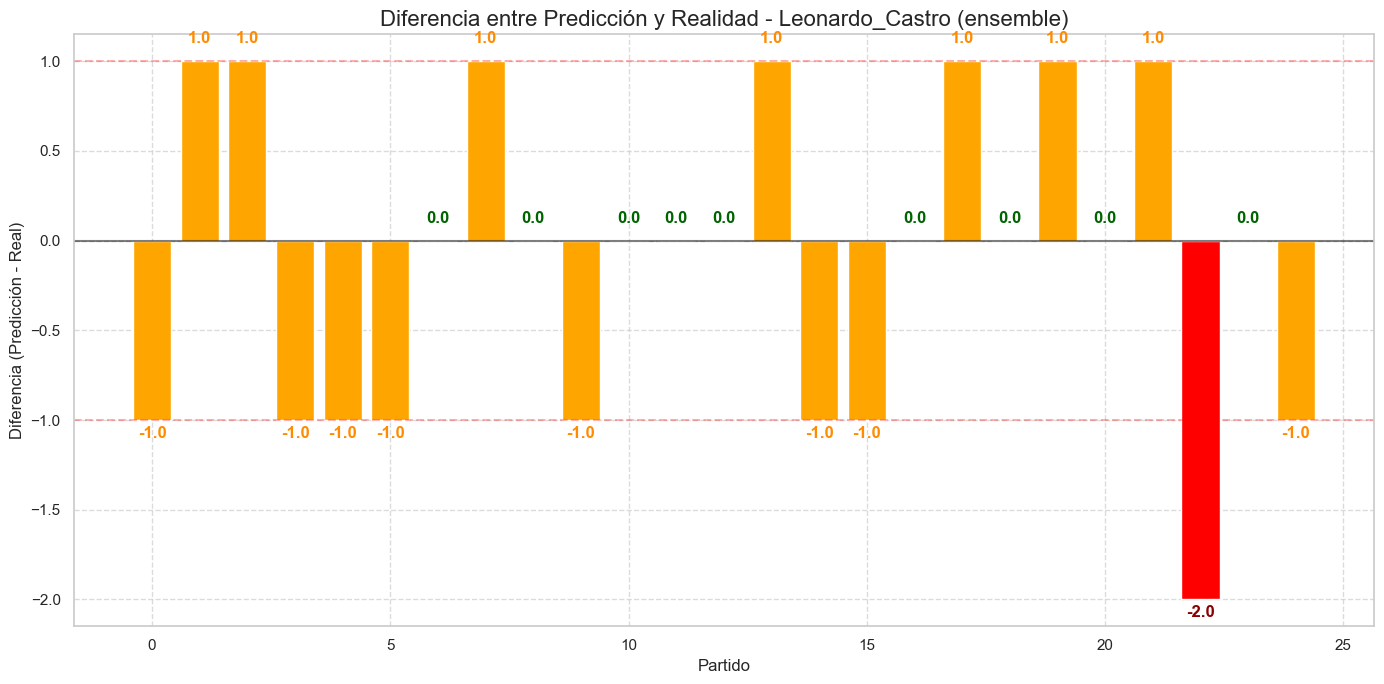

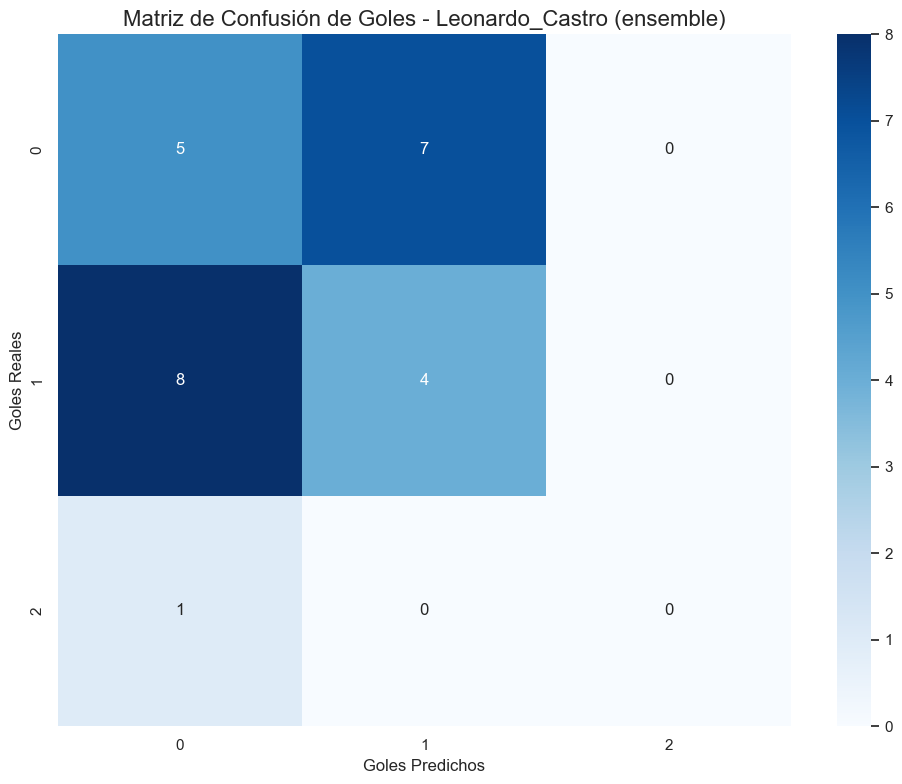

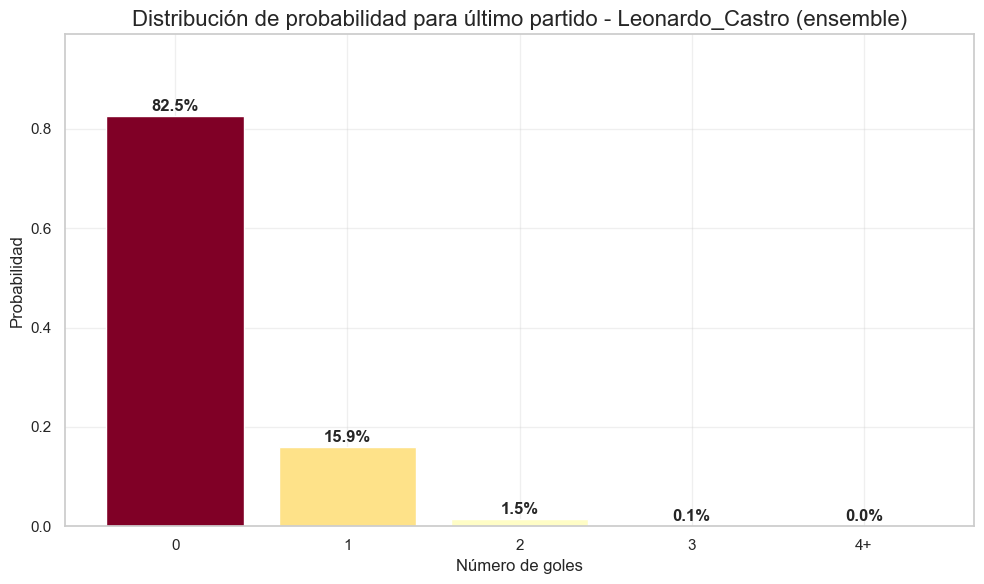


Predicciones para partidos futuros de Leonardo_Castro:
Modelo LSTM (ensemble) cargado para Leonardo_Castro
Equipo actual de Leonardo_Castro: Millonarios
Encontrados 20 partidos futuros para Millonarios
Característica 'Factor_Oponente' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_5' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Marco_Ultimo_Partido' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Ult_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Tendencia_Robusta' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Es_FinDeSemana' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Racha_Con_Gol' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_7' no encontrada

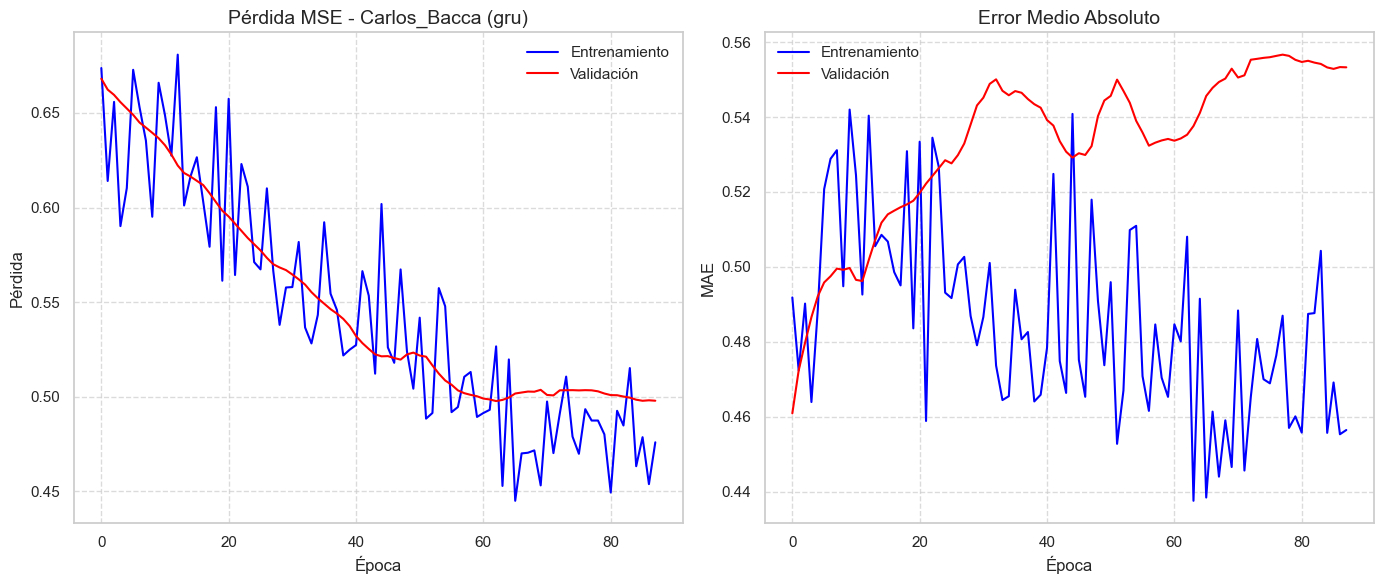

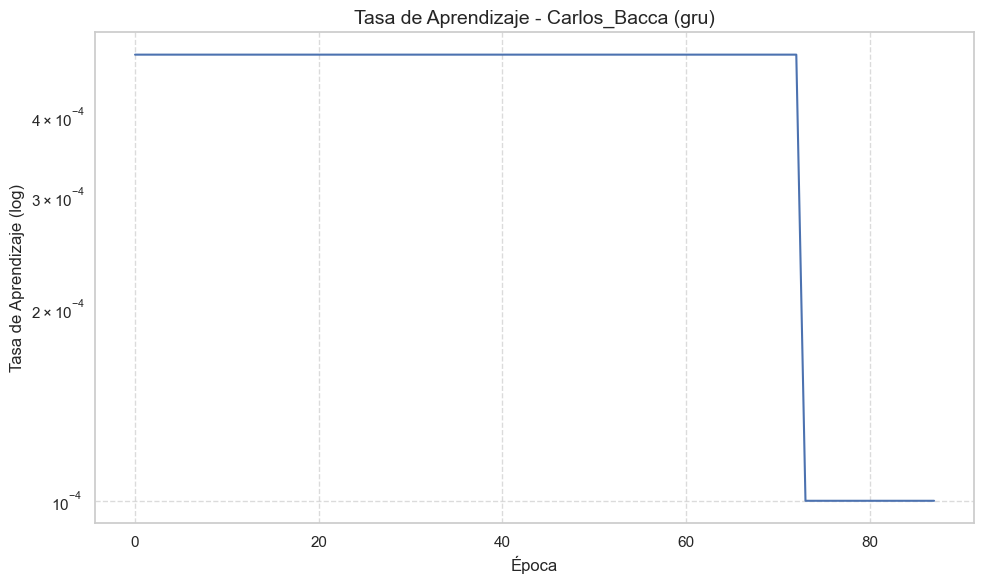

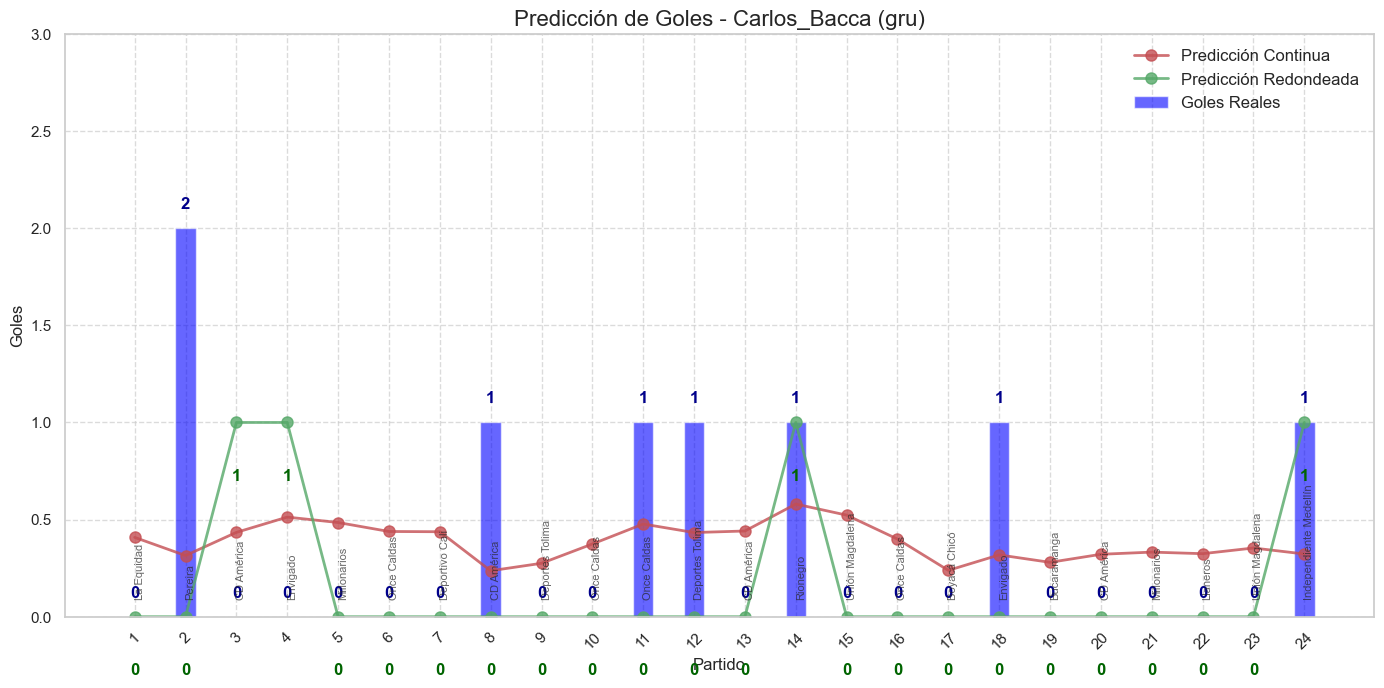

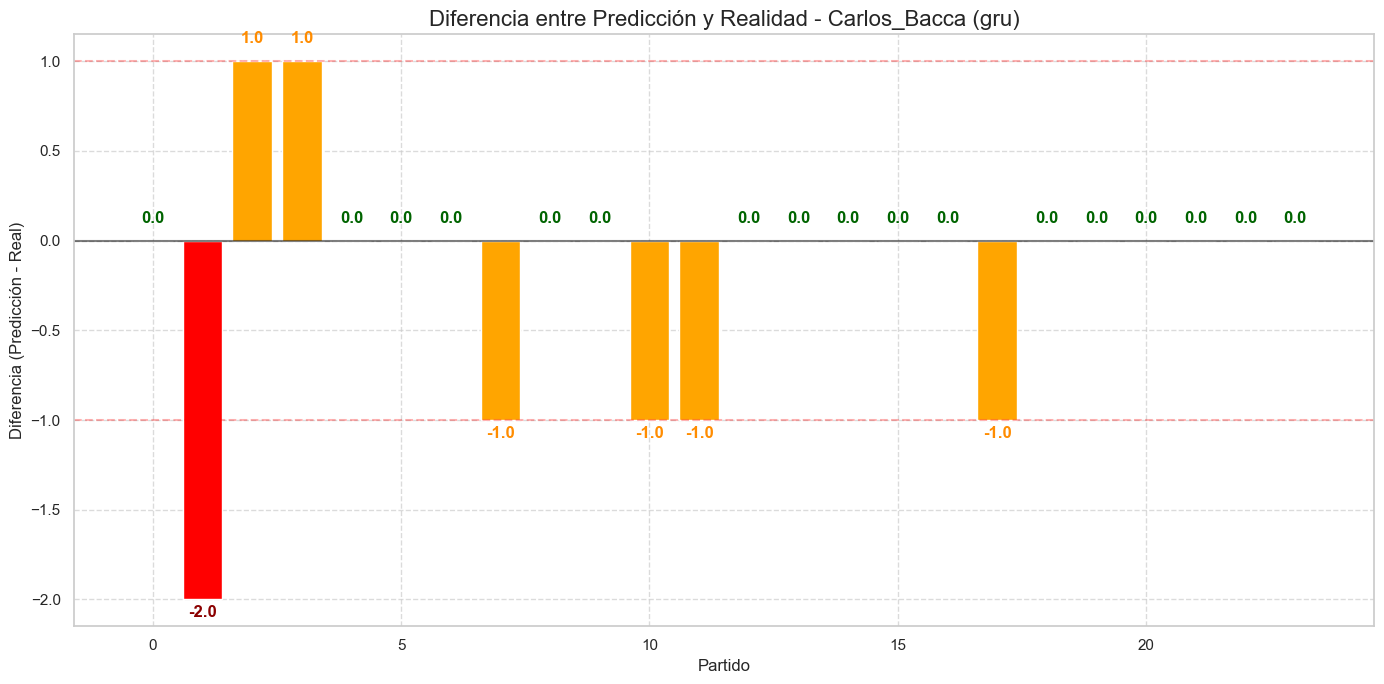

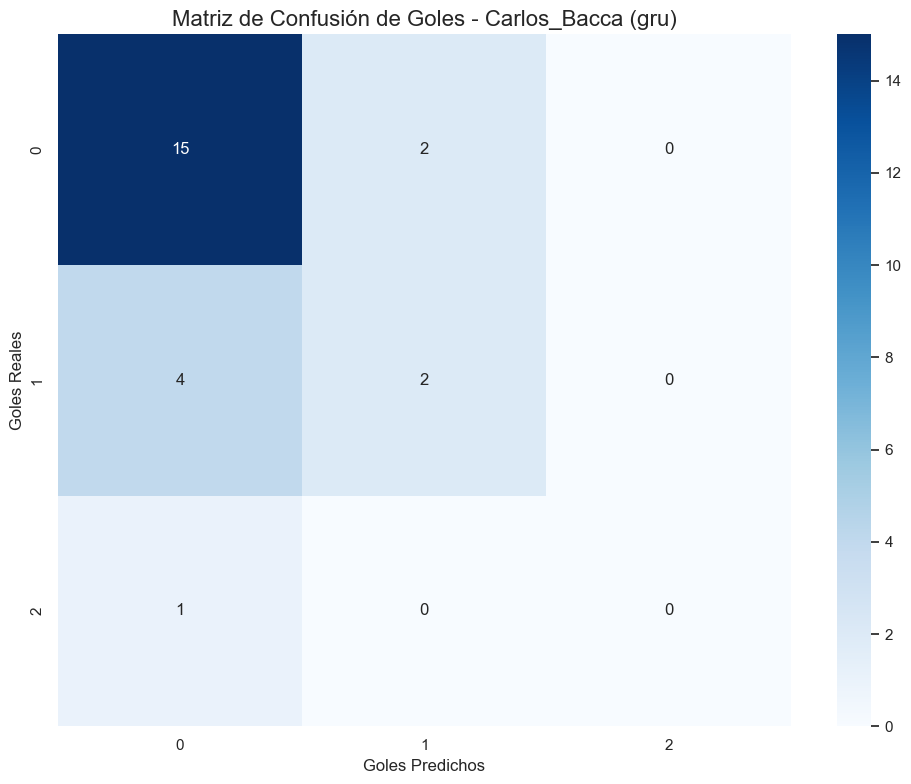

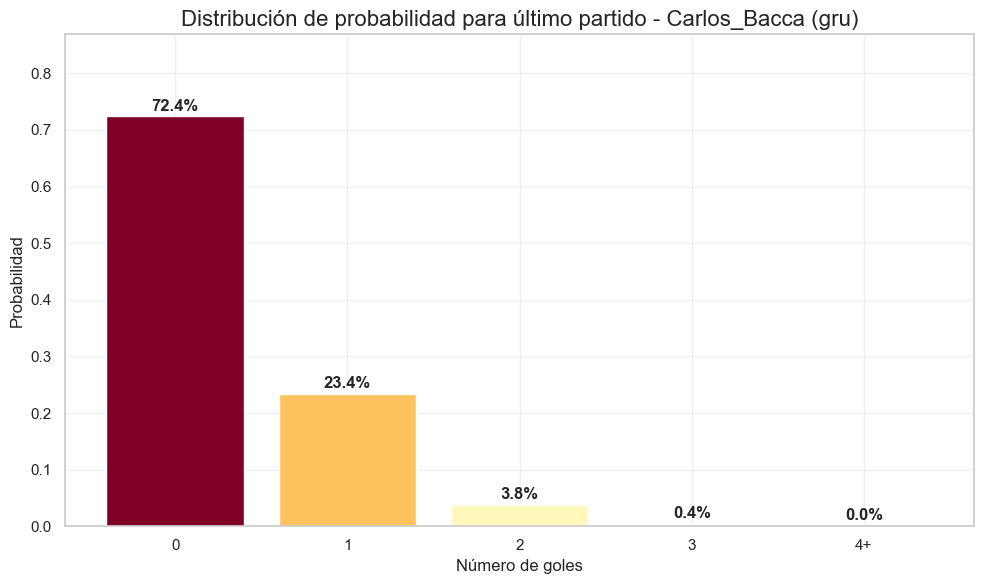


Predicciones para partidos futuros de Carlos_Bacca:
Modelo LSTM (gru) cargado para Carlos_Bacca
Equipo actual de Carlos_Bacca: Junior
Encontrados 20 partidos futuros para Junior
Característica 'Factor_Oponente' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_5' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Marco_Ultimo_Partido' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Ult_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Tendencia_Robusta' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Es_FinDeSemana' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Racha_Con_Gol' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_7' no encontrada en los datos. Creando c

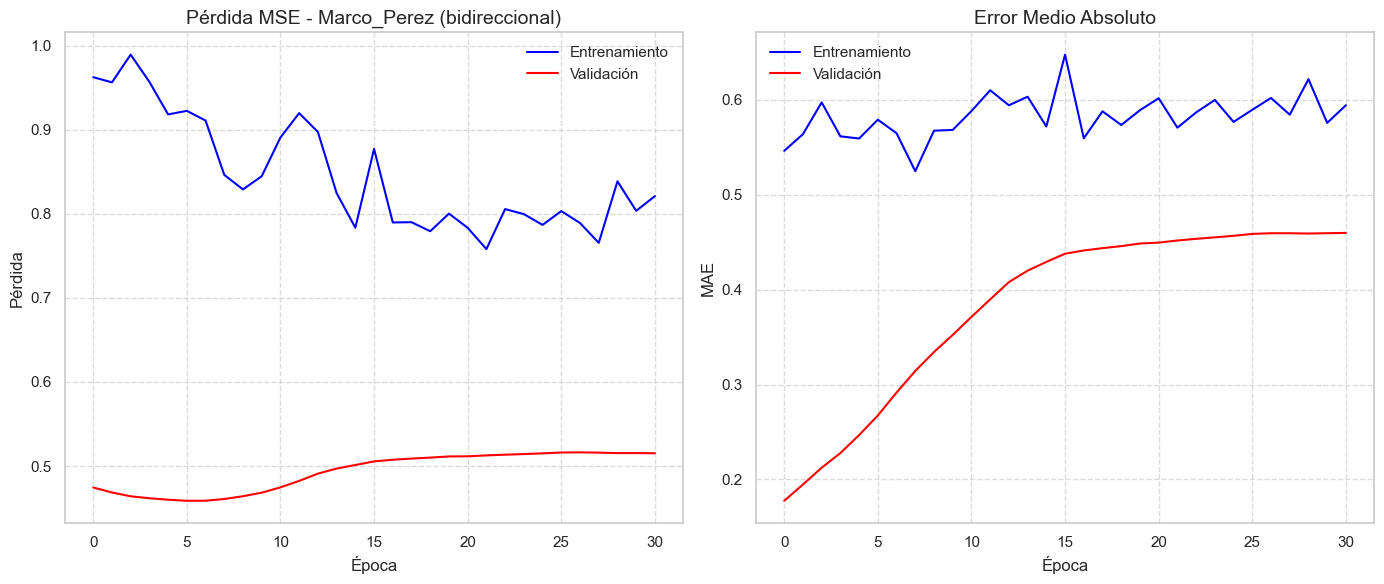

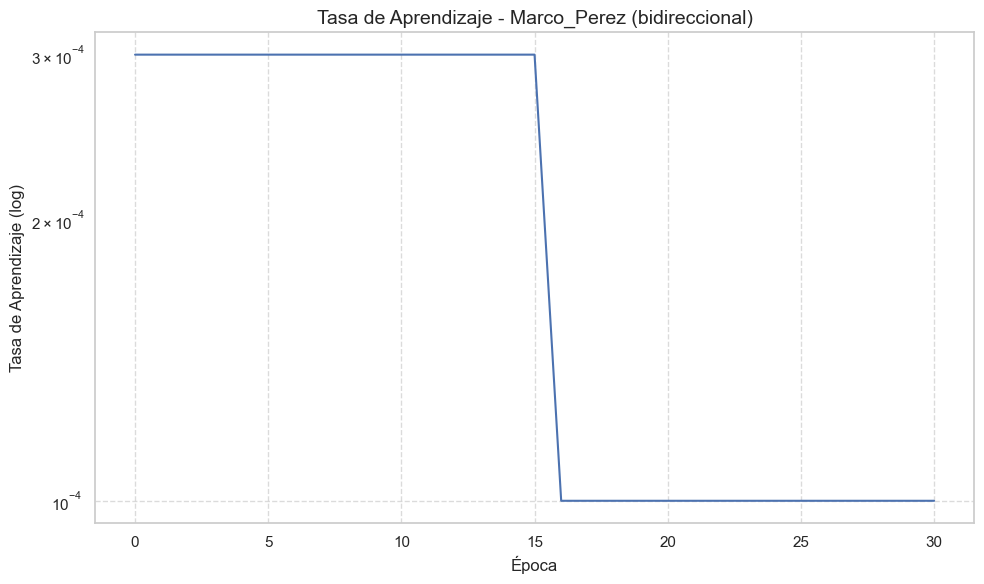

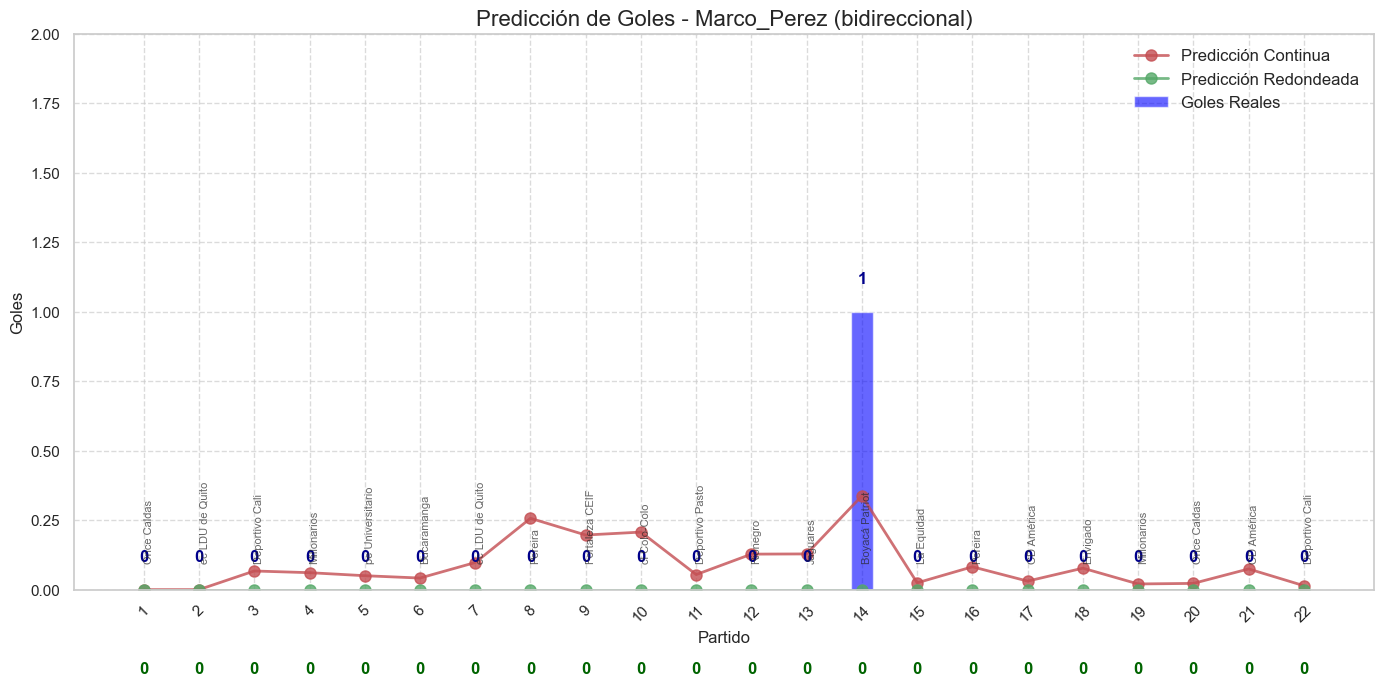

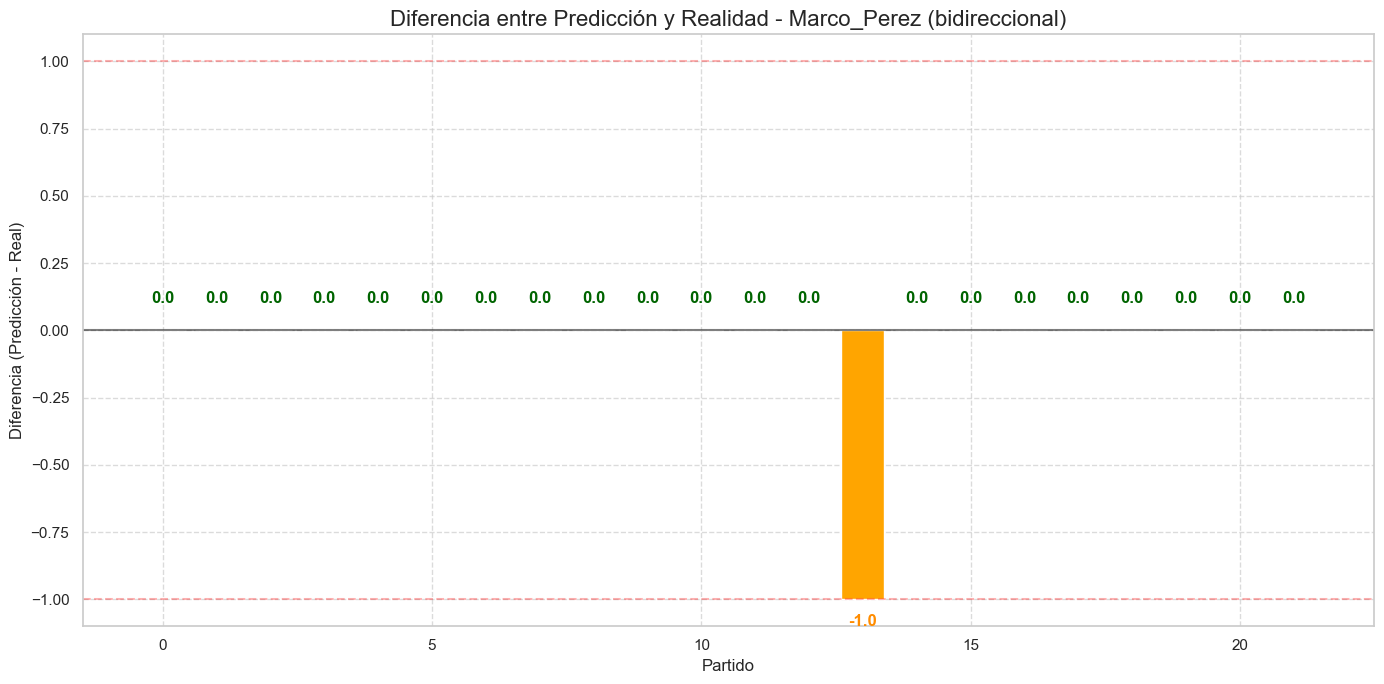

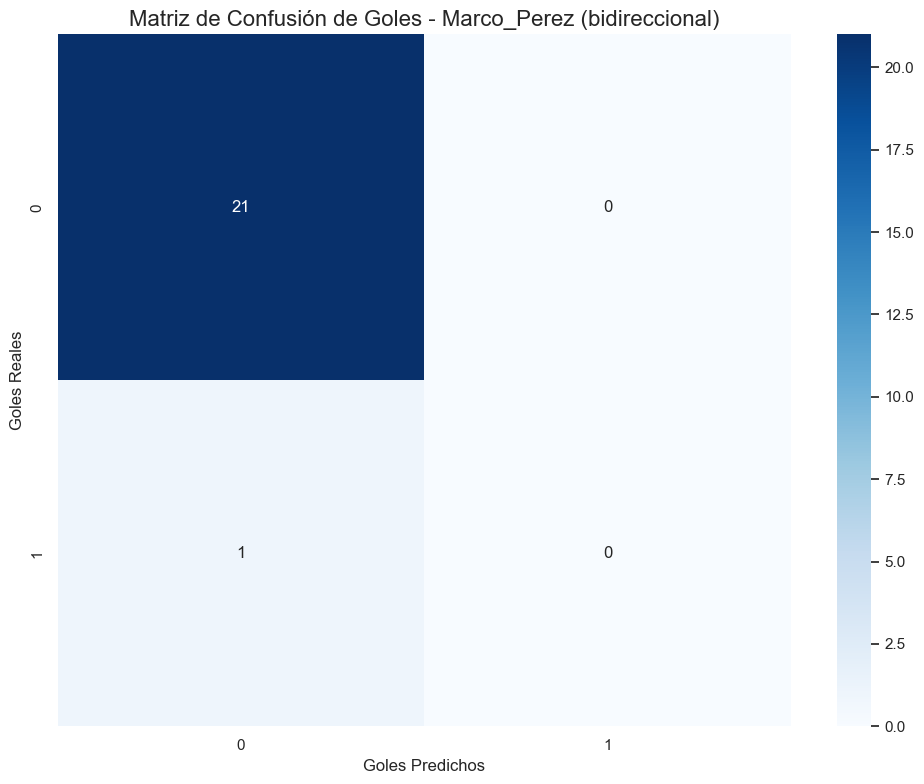

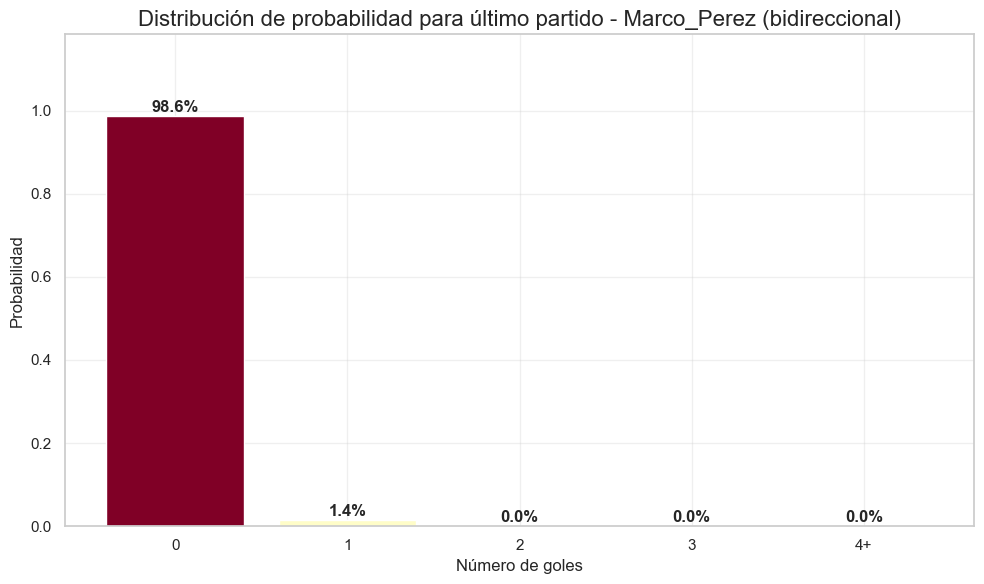


Predicciones para partidos futuros de Marco_Perez:
Modelo LSTM (bidireccional) cargado para Marco_Perez
Equipo actual de Marco_Perez: Junior
Encontrados 20 partidos futuros para Junior
Característica 'Factor_Oponente' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_5' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Marco_Ultimo_Partido' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Ult_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Tendencia_Robusta' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Es_FinDeSemana' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Racha_Con_Gol' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_7' no encontrada en los datos. Cr

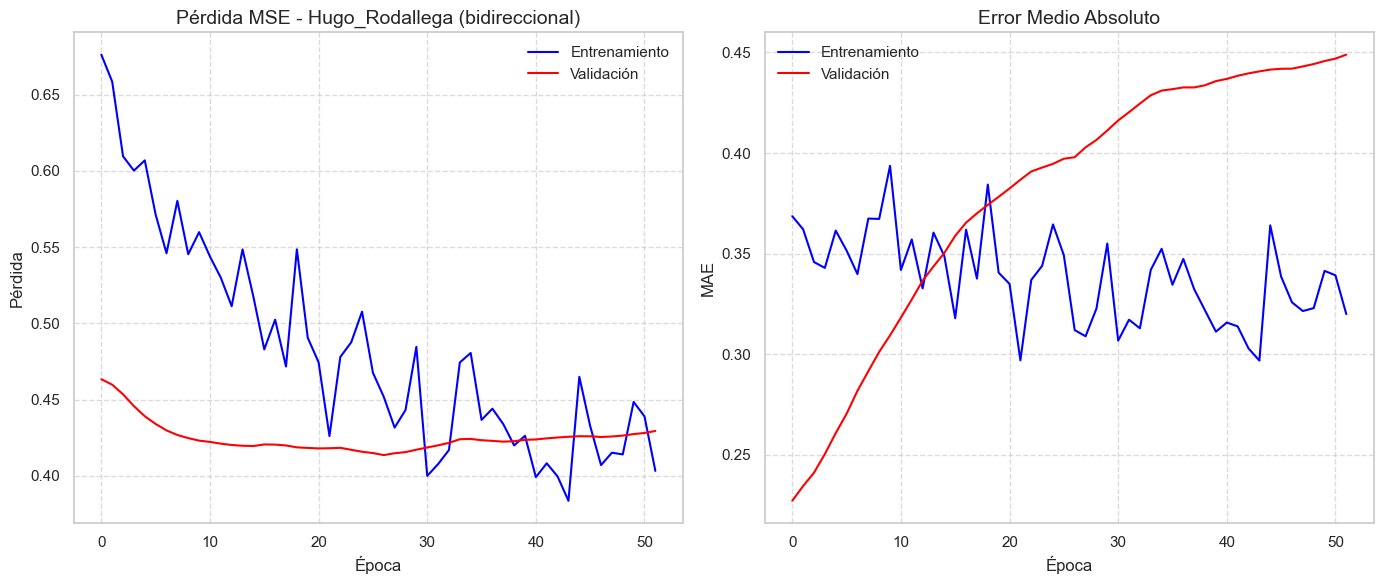

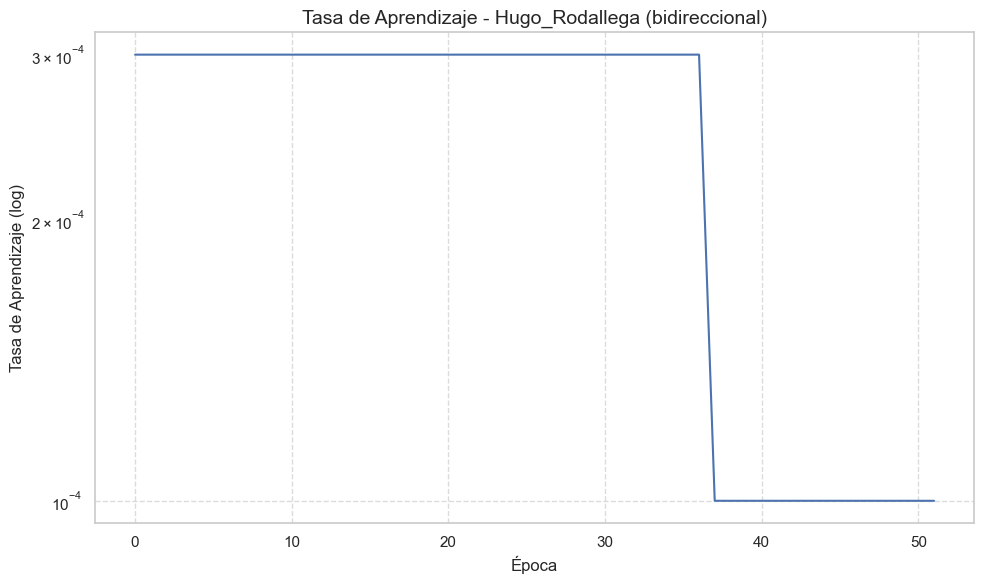

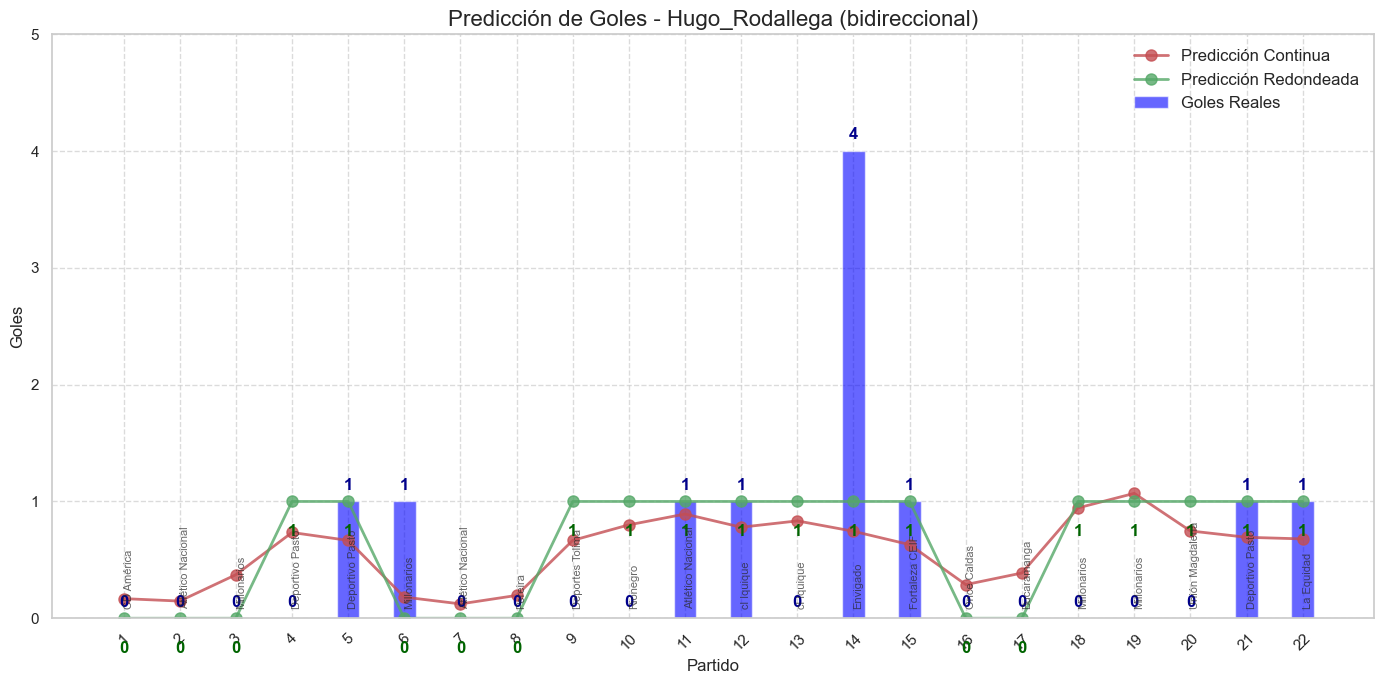

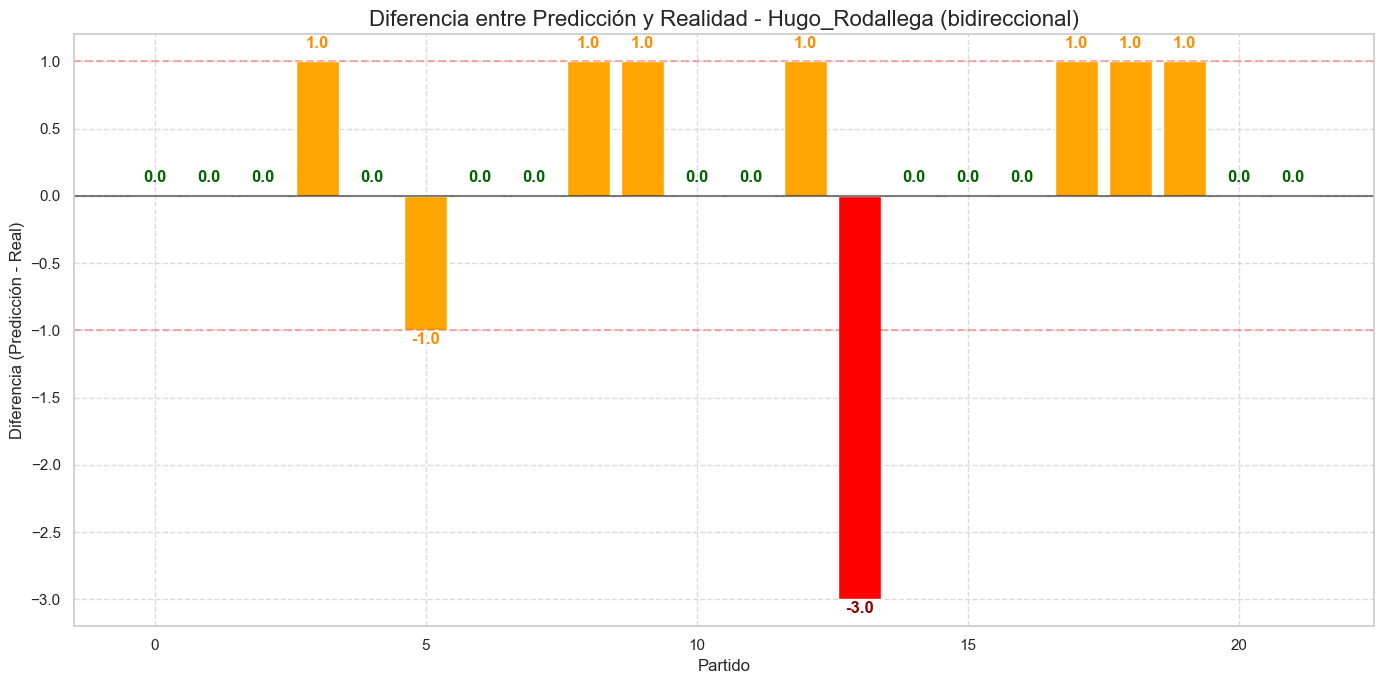

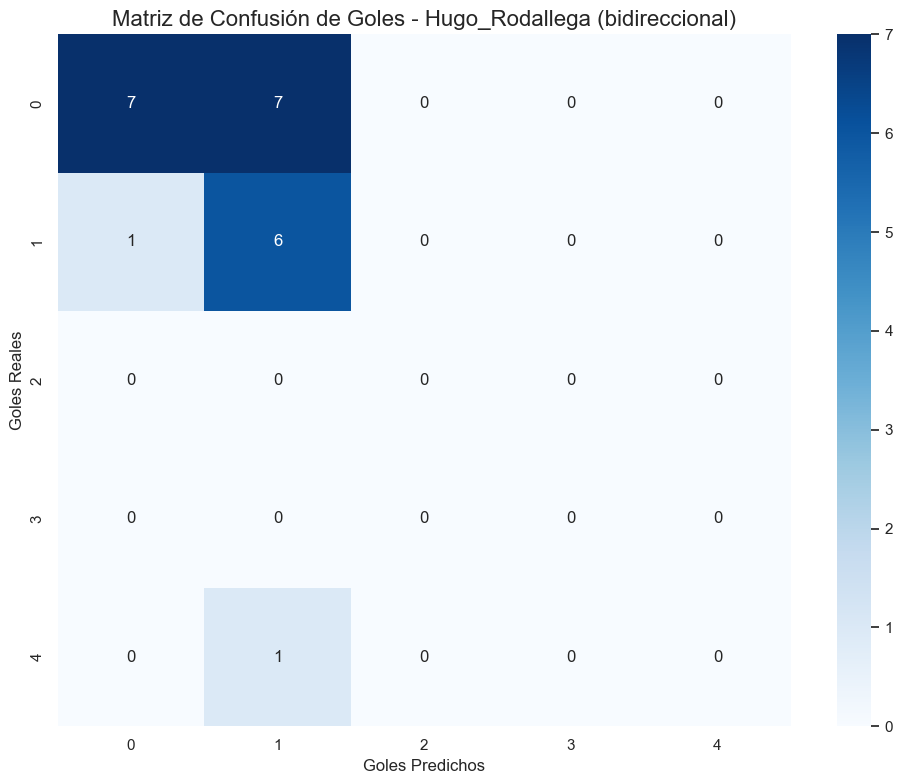

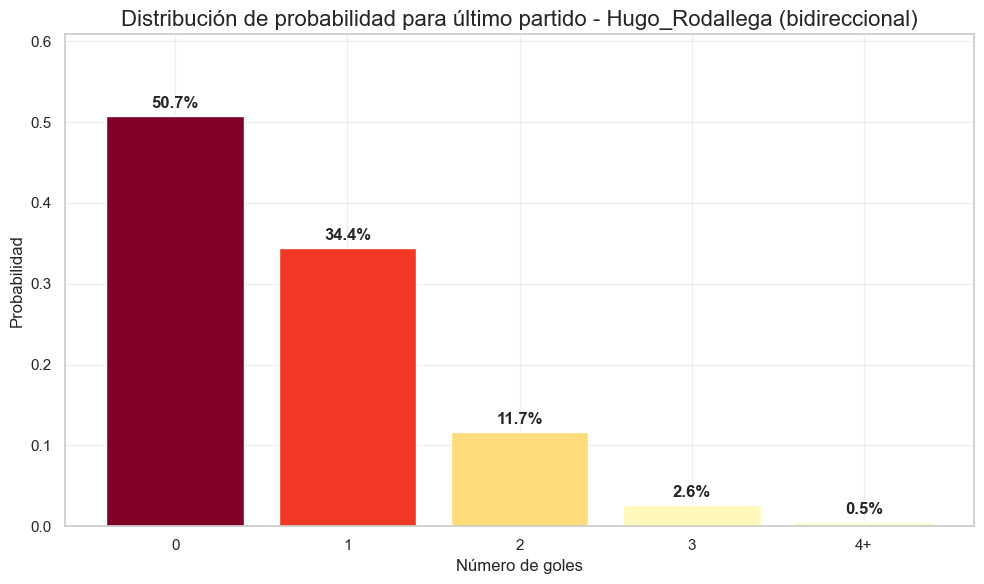


Predicciones para partidos futuros de Hugo_Rodallega:
Modelo LSTM (bidireccional) cargado para Hugo_Rodallega
Equipo actual de Hugo_Rodallega: Independiente Santa Fe
Encontrados 20 partidos futuros para Independiente Santa Fe
Característica 'Factor_Oponente' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Prom_5' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Marco_Ultimo_Partido' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Goles_Ult_3' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Tendencia_Robusta' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Es_FinDeSemana' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Racha_Con_Gol' no encontrada en los datos. Creando con valor predeterminado.
Característica 'Gol

<Figure size 1200x600 with 0 Axes>

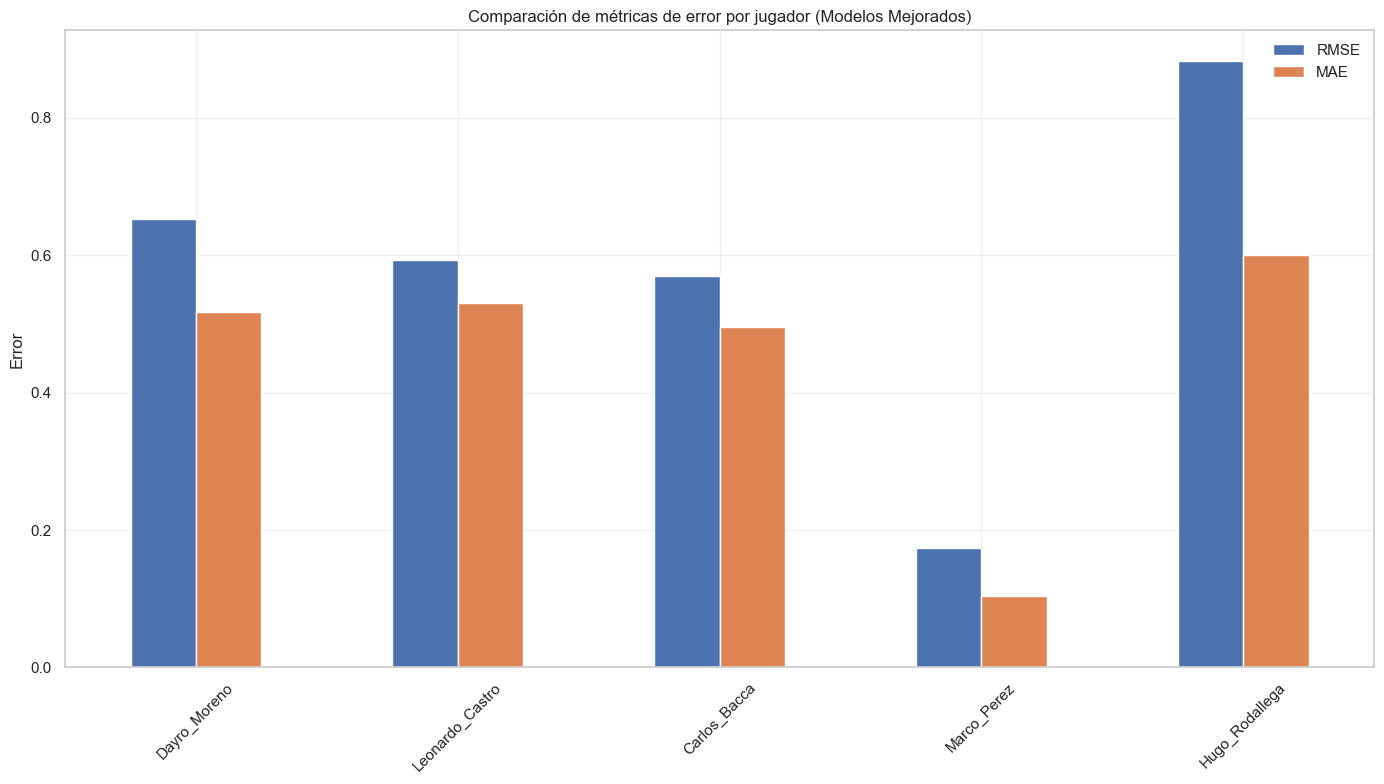

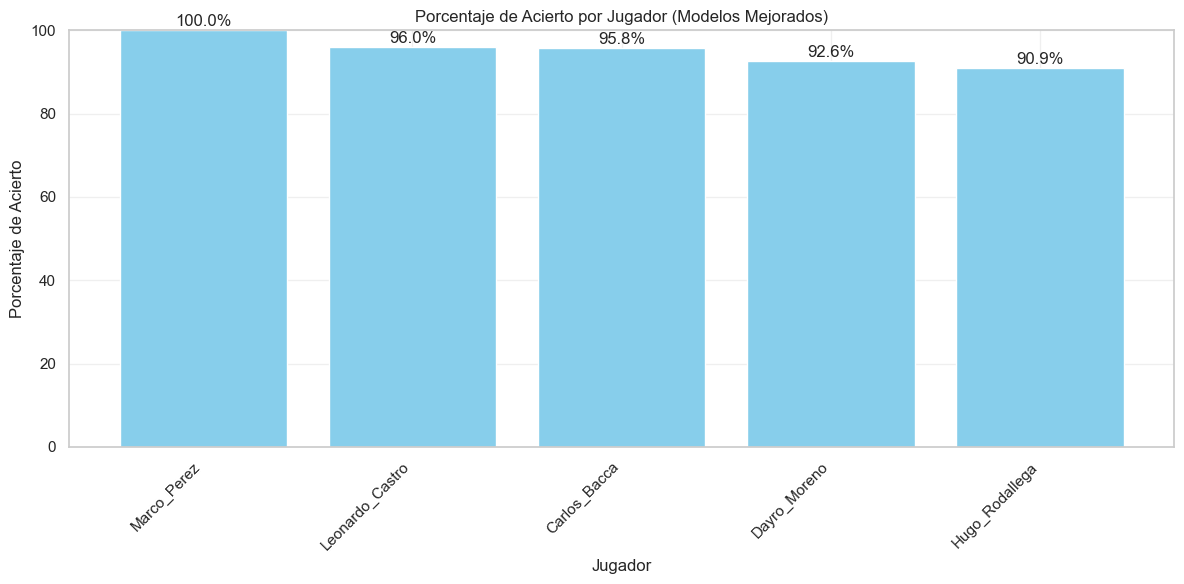

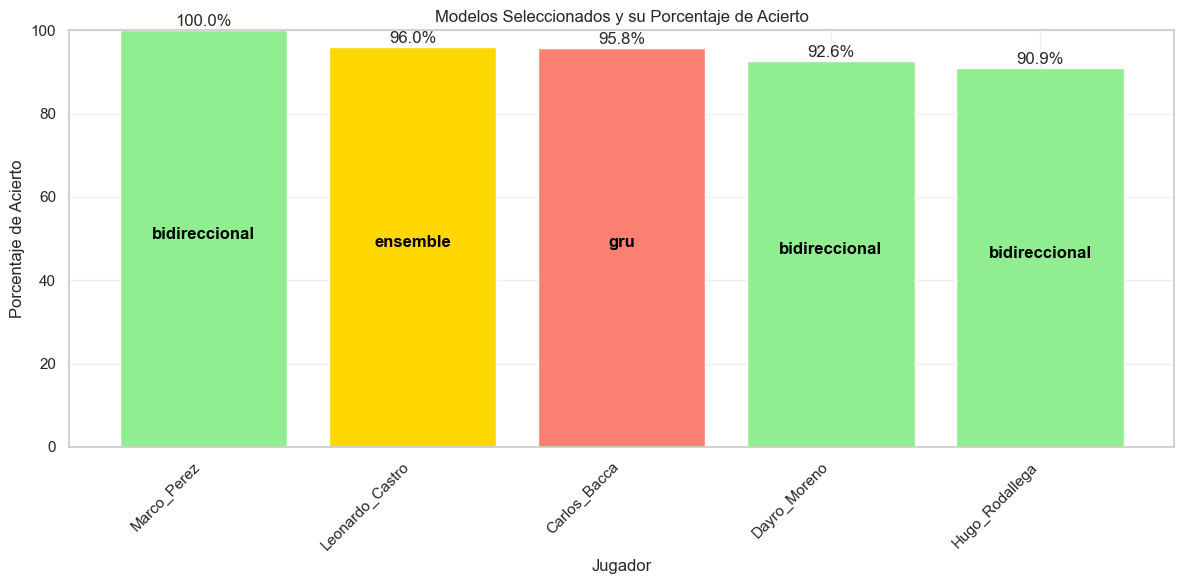


Proceso completo finalizado exitosamente!


In [ ]:
# Bloque 1: Importación de Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time
import warnings
from tqdm.notebook import tqdm
import math
from datetime import datetime, timedelta

# Para modelos y procesamiento
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Dropout, Input, GRU, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l1, l2, l1_l2
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats
from scipy.stats import poisson

# Ignorar advertencias
warnings.filterwarnings('ignore')

# Configurar semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuración para gráficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Para configurar la visualización de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Bibliotecas importadas correctamente para modelo LSTM mejorado.")

# Crear directorio para modelos si no existe
if not os.path.exists('modelos_lstm'):
    os.makedirs('modelos_lstm')
    print("Directorio 'modelos_lstm' creado correctamente.")

# Bloque 2: Funciones para Preparación de Datos

def calcular_porcentaje_acierto(y_true, y_pred):
    """
    Calcula el porcentaje de acierto (diferencia menor a 1 gol)
    
    Args:
        y_true: Valores reales
        y_pred: Valores predichos
    
    Returns:
        Porcentaje de aciertos
    """
    aciertos = np.sum(np.abs(y_true - np.array(y_pred)) < 1)
    return (aciertos / len(y_true)) * 100

def calcular_tendencia_robusta(serie, ventanas=[3, 5, 7]):
    """
    Calcula la tendencia de una serie de forma más robusta usando múltiples 
    ventanas temporales y promediando los resultados.
    
    Args:
        serie: Serie de datos
        ventanas: Tamaños de ventana para calcular la tendencia
    
    Returns:
        Serie con la tendencia calculada
    """
    tendencias = pd.Series(0, index=serie.index)
    pesos = {3: 0.5, 5: 0.3, 7: 0.2}  # Pesos para diferentes ventanas
    
    for ventana in ventanas:
        if len(serie) >= ventana:
            for i in range(ventana, len(serie) + 1):
                try:
                    # Obtener datos de la ventana actual
                    datos_ventana = serie.iloc[i-ventana:i].values
                    x = np.arange(ventana)
                    # Regresión lineal para calcular la pendiente
                    slope, _, _, _, _ = stats.linregress(x, datos_ventana)
                    idx = serie.index[i-1]
                    tendencias.loc[idx] += slope * pesos[ventana]
                except:
                    pass
    
    return tendencias

def calcular_factores_oponente(df_jugador, equipos_similares=None):
    """
    Calcula factores avanzados para oponentes, incluyendo rendimiento histórico
    y similitud entre equipos.
    
    Args:
        df_jugador: DataFrame con los datos del jugador
        equipos_similares: Diccionario de equipos similares
    
    Returns:
        DataFrame actualizado con factores de oponente
    """
    # Inicializar factor básico
    df_jugador['Factor_Oponente'] = 1.0
    
    # Calcular el factor tradicional basado en historial directo
    oponentes_unicos = df_jugador['Oponente_Estandarizado'].unique()
    for oponente in oponentes_unicos:
        df_oponente = df_jugador[df_jugador['Oponente_Estandarizado'] == oponente].copy()
        
        for idx, row in df_oponente.iterrows():
            fecha_actual = row['Fecha']
            # Historial directo contra este oponente
            hist_directo = df_oponente[(df_oponente['Fecha'] < fecha_actual)]
            
            factor = 1.0
            if len(hist_directo) > 0:
                promedio_vs_oponente = hist_directo['Goles'].mean()
                # Normalizar para crear un factor multiplicativo
                factor = (promedio_vs_oponente + 1) / (df_jugador['Goles'].mean() + 1)
                
                # Dar más peso a partidos recientes (últimos 3)
                hist_reciente = hist_directo.sort_values('Fecha').tail(3)
                if len(hist_reciente) > 0:
                    factor_reciente = (hist_reciente['Goles'].mean() + 1) / (df_jugador['Goles'].mean() + 1)
                    # Combinar factor histórico (peso 0.7) y reciente (peso 0.3)
                    factor = 0.7 * factor + 0.3 * factor_reciente
            
            df_jugador.loc[idx, 'Factor_Oponente'] = factor
    
    # Si tenemos equipos similares, añadir factor basado en similitud
    if equipos_similares:
        # Implementación para equipos similares (si está disponible)
        df_jugador['Factor_Equipos_Similares'] = 1.0
    
    return df_jugador

def obtener_perfil_jugador(df_jugador):
    """
    Obtiene el perfil estadístico de un jugador para entender sus patrones.
    
    Args:
        df_jugador: DataFrame con datos del jugador
        
    Returns:
        Diccionario con el perfil estadístico
    """
    # Calcular estadísticas generales
    perfil = {
        'goles_promedio': df_jugador['Goles'].mean(),
        'goles_std': df_jugador['Goles'].std(),
        'goles_max': df_jugador['Goles'].max(),
        'porcentaje_partidos_con_gol': (df_jugador['Goles'] > 0).mean() * 100,
        'rendimiento_local': df_jugador[df_jugador['Sede_Local'] == 1]['Goles'].mean(),
        'rendimiento_visitante': df_jugador[df_jugador['Sede_Visitante'] == 1]['Goles'].mean(),
        'ratio_local_visitante': 1.0  # Valor por defecto
    }
    
    # Calcular ratio local/visitante si ambos tienen partidos
    if perfil['rendimiento_visitante'] > 0:
        perfil['ratio_local_visitante'] = perfil['rendimiento_local'] / perfil['rendimiento_visitante']
    
    return perfil

def preparar_datos_lstm_mejorado(df_original, jugador_id, test_size=0.2):
    """
    Prepara características para el modelo LSTM con mejoras en las características.
    
    Args:
        df_original: DataFrame con datos históricos
        jugador_id: Nombre del jugador
        test_size: Proporción de datos para prueba
        
    Returns:
        Tupla con datos completos, entrenamiento, prueba y características
    """
    print(f"\n--- Preparando datos para {jugador_id} ---")
    
    # Filtrar datos para el jugador y ordenar cronológicamente
    df_jugador = df_original[df_original['Jugador'] == jugador_id].copy().sort_values('Fecha')
    
    # Mismo filtro para Hugo Rodallega que tenías en el modelo Poisson
    if jugador_id == 'Hugo Rodallega':
        fecha_inicio = pd.Timestamp('2023-01-01')
        df_jugador = df_jugador[df_jugador['Fecha'] >= fecha_inicio]
        print(f"Filtrando datos de {jugador_id} desde {fecha_inicio.strftime('%d/%m/%Y')}")
    
    if df_jugador.empty:
        print(f"No hay datos disponibles para {jugador_id}")
        return None, None, None, None, None
    
    # Renombrar columnas con espacios
    rename_dict = {}
    for col in df_jugador.columns:
        if ' ' in col:
            new_name = col.replace(' ', '_')
            rename_dict[col] = new_name
    
    if rename_dict:
        df_jugador = df_jugador.rename(columns=rename_dict)
    
    # Obtener perfil estadístico del jugador
    perfil_jugador = obtener_perfil_jugador(df_jugador)
    print(f"Perfil estadístico de {jugador_id}:")
    for key, value in perfil_jugador.items():
        print(f"  - {key}: {value:.2f}")
    
    # ===== CARACTERÍSTICAS MEJORADAS =====
    
    # 1. Promedios móviles de goles (más ventanas)
    try:
        for ventana in [3, 5, 7, 10]:
            if len(df_jugador) >= ventana:
                col_name = f'Goles_Prom_{ventana}'
                df_jugador[col_name] = df_jugador['Goles'].rolling(window=ventana, min_periods=1).mean()
    except Exception as e:
        print(f"Error al calcular promedios móviles: {str(e)}")
        # Asegurarse de que las columnas existan
        df_jugador['Goles_Prom_3'] = df_jugador['Goles'].rolling(window=3, min_periods=1).mean()
        df_jugador['Goles_Prom_5'] = df_jugador['Goles'].rolling(window=5, min_periods=1).mean()
    
    # 2. Cálculo de factores de oponente mejorados
    try:
        df_jugador = calcular_factores_oponente(df_jugador)
    except Exception as e:
        print(f"Error al calcular Factor_Oponente: {str(e)}")
        # Asegurarse de que la columna exista
        df_jugador['Factor_Oponente'] = 1.0
    
    # 3. Tendencia robusta (usa múltiples ventanas)
    try:
        df_jugador['Tendencia_Robusta'] = calcular_tendencia_robusta(df_jugador['Goles'])
    except Exception as e:
        print(f"Error al calcular Tendencia_Robusta: {str(e)}")
        df_jugador['Tendencia_Robusta'] = 0
    
    # 4. Variables para marcar partidos recientes
    try:
        df_jugador['Marco_Ultimo_Partido'] = df_jugador['Goles'].shift(1).fillna(0)
        df_jugador['Goles_Ult_3'] = df_jugador['Goles'].rolling(window=3, min_periods=1).sum()
        df_jugador['Goles_Ult_5'] = df_jugador['Goles'].rolling(window=5, min_periods=1).sum()
        
        # Secuencias de partidos con/sin gol
        goles_binario = (df_jugador['Goles'] > 0).astype(int)
        df_jugador['Racha_Con_Gol'] = goles_binario.groupby((goles_binario != goles_binario.shift()).cumsum()).cumcount()
        
        # Goles contra oponentes fuertes/débiles
        if 'Indice_Ofensivo' in df_jugador.columns:
            # Oponentes con alto índice ofensivo
            alto_indice = df_jugador['Indice_Ofensivo'] > df_jugador['Indice_Ofensivo'].median()
            df_jugador['Goles_vs_Fuertes'] = df_jugador.loc[alto_indice, 'Goles'].rolling(window=5, min_periods=1).mean().reindex(df_jugador.index).fillna(0)
    except Exception as e:
        print(f"Error al calcular variables de partidos recientes: {str(e)}")
        # Asegurarse de que las columnas existan
        df_jugador['Marco_Ultimo_Partido'] = 0
        df_jugador['Goles_Ult_3'] = 0
        df_jugador['Racha_Con_Gol'] = 0
    
    # 5. Factores de contexto y temporada
    try:
        # Día de la semana
        if 'Día_de_la_semana' in df_jugador.columns:
            day_mapping = {
                'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
                'Friday': 4, 'Saturday': 5, 'Sunday': 6,
                'Lunes': 0, 'Martes': 1, 'Miércoles': 2, 'Jueves': 3,
                'Viernes': 4, 'Sábado': 5, 'Domingo': 6
            }
            df_jugador['Dia_Num'] = df_jugador['Día_de_la_semana'].map(day_mapping)
            
            # Días de fin de semana como factor
            df_jugador['Es_FinDeSemana'] = df_jugador['Dia_Num'].apply(lambda x: 1 if x >= 4 else 0)
        
        # Rendimiento por temporada
        if 'Temporada' in df_jugador.columns:
            temporadas = df_jugador['Temporada'].unique()
            for temp in temporadas:
                temp_data = df_jugador[df_jugador['Temporada'] == temp]
                avg_goles = temp_data['Goles'].mean()
                df_jugador.loc[df_jugador['Temporada'] == temp, 'Rendimiento_Temporada'] = avg_goles
        
        # Eficiencia y Precisión
        if 'Tiros_totales' in df_jugador.columns and 'Tiros_a_puerta' in df_jugador.columns:
            # Calcular eficiencia en ventana móvil
            df_jugador['Tiros_totales_5'] = df_jugador['Tiros_totales'].rolling(window=5, min_periods=1).sum()
            df_jugador['Goles_5'] = df_jugador['Goles'].rolling(window=5, min_periods=1).sum()
            
            # Evitar divisiones por cero
            mascara = df_jugador['Tiros_totales_5'] > 0
            df_jugador.loc[mascara, 'Eficiencia_5'] = df_jugador.loc[mascara, 'Goles_5'] / df_jugador.loc[mascara, 'Tiros_totales_5']
            df_jugador.loc[~mascara, 'Eficiencia_5'] = 0
    except Exception as e:
        print(f"Error al calcular factores de contexto: {str(e)}")
        # Asegurarse de que las columnas existan
        df_jugador['Es_FinDeSemana'] = 0
        df_jugador['Rendimiento_Temporada'] = df_jugador['Goles'].mean()
    
    # Llenar NaNs con 0
    df_jugador = df_jugador.fillna(0)
    
    # Seleccionar características clave basadas en el análisis mejorado
    caracteristicas_clave = [
        'Tiros_a_puerta', 'Tiros_totales', 'Minutos',
        'Sede_Local', 'Sede_Visitante',
        'Factor_Oponente', 'Goles_Prom_3', 'Goles_Prom_5',
        'Marco_Ultimo_Partido', 'Goles_Ult_3', 'Tendencia_Robusta',
        'Es_FinDeSemana', 'Racha_Con_Gol', 'Goles_Prom_7'
    ]
    
    # Añadir características adicionales si existen
    caracteristicas_opcionales = [
        'Eficiencia_5', 'Goles_vs_Fuertes', 'Rendimiento_Temporada', 
        'Goles_Prom_10', 'Goles_Ult_5'
    ]
    
    for feat in caracteristicas_opcionales:
        if feat in df_jugador.columns:
            caracteristicas_clave.append(feat)
    
    # Asegurarse de que todas las características existan en el DataFrame
    for feature in caracteristicas_clave:
        if feature not in df_jugador.columns:
            print(f"Característica '{feature}' no encontrada, creando con valor predeterminado 0")
            df_jugador[feature] = 0.0
    
    # Filtrar solo las características que existen
    caracteristicas_disponibles = [c for c in caracteristicas_clave if c in df_jugador.columns]
    
    print(f"Características seleccionadas: {caracteristicas_disponibles}")
    
    # División de datos en entrenamiento y prueba
    train_size = int(len(df_jugador) * (1 - test_size))
    df_train = df_jugador.iloc[:train_size].copy()
    df_test = df_jugador.iloc[train_size:].copy()
    
    print(f"Datos preparados para {jugador_id}: {len(df_jugador)} registros")
    print(f"Conjunto de entrenamiento: {len(df_train)} partidos")
    print(f"Conjunto de prueba: {len(df_test)} partidos")
    
    # Guardar información de normalización para usar en predicciones
    normalization_info = {}
    for feature in caracteristicas_disponibles:
        if feature in df_jugador.columns:
            normalization_info[feature] = {
                'mean': df_jugador[feature].mean(),
                'std': df_jugador[feature].std() if df_jugador[feature].std() > 0 else 1.0
            }
    
    # Incluir el perfil del jugador en la información de normalización
    normalization_info['perfil_jugador'] = perfil_jugador
    
    return df_jugador, df_train, df_test, caracteristicas_disponibles, normalization_info

def crear_secuencias(df, caracteristicas, ventana=3, include_labels=True):
    """
    Crea secuencias para el modelo LSTM.
    
    Args:
        df: DataFrame con datos históricos
        caracteristicas: Lista de características a incluir
        ventana: Número de partidos anteriores a considerar
        include_labels: Si se deben incluir etiquetas (False para predicción)
    
    Returns:
        Tupla con X, y, fechas, oponentes
    """
    if df.empty:
        return np.array([]), np.array([]), [], []
    
    X, y, fechas, oponentes = [], [], [], []
    
    # Si solo necesitamos X para predecir (sin etiquetas)
    if not include_labels:
        # Usar los últimos 'ventana' registros
        if len(df) >= ventana:
            ultimos_datos = df.iloc[-ventana:][caracteristicas].values
            X.append(ultimos_datos)
            fechas.append(df.iloc[-1]['Fecha'])
            oponentes.append(df.iloc[-1]['Oponente_Estandarizado'])
    else:
        # Crear secuencias para entrenamiento/validación
        for i in range(ventana, len(df)):
            # Secuencia de ventana partidos anteriores
            X.append(df.iloc[i-ventana:i][caracteristicas].values)
            
            # Variable objetivo: Número exacto de goles
            y.append(df.iloc[i]['Goles'])
            
            # Información adicional para análisis
            fechas.append(df.iloc[i]['Fecha'])
            oponentes.append(df.iloc[i]['Oponente_Estandarizado'])
    
    return np.array(X), np.array(y), fechas, oponentes

# Bloque 3: Modelos Mejorados

def crear_modelo_lstm_simple(input_shape, dropout_rate=0.3):
    """
    Crea un modelo LSTM sencillo con regularización mejorada.
    
    Args:
        input_shape: Forma de entrada (ventana, n_features)
        dropout_rate: Tasa de dropout para regularización
        
    Returns:
        Modelo compilado
    """
    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=False, 
             dropout=dropout_rate, recurrent_dropout=dropout_rate),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate),
        Dense(1, activation='relu')
    ])
    
    # Compilación con optimizador Adam y tasa de aprendizaje reducida
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def crear_modelo_lstm_bidireccional(input_shape, dropout_rate=0.3):
    """
    Crea un modelo LSTM bidireccional para capturar patrones en ambas direcciones.
    
    Args:
        input_shape: Forma de entrada (ventana, n_features)
        dropout_rate: Tasa de dropout para regularización
        
    Returns:
        Modelo compilado
    """
    model = Sequential([
        Bidirectional(LSTM(32, dropout=dropout_rate, recurrent_dropout=dropout_rate), 
                     input_shape=input_shape),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate),
        Dense(1, activation='relu')
    ])
    
    # Compilación con optimizador Adam y tasa de aprendizaje reducida
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def crear_modelo_gru(input_shape, dropout_rate=0.3):
    """
    Crea un modelo GRU como alternativa al LSTM.
    
    Args:
        input_shape: Forma de entrada (ventana, n_features)
        dropout_rate: Tasa de dropout para regularización
        
    Returns:
        Modelo compilado
    """
    model = Sequential([
        GRU(32, input_shape=input_shape, return_sequences=False,
            dropout=dropout_rate, recurrent_dropout=dropout_rate),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate),
        Dense(1, activation='relu')
    ])
    
    # Compilación con optimizador Adam y tasa de aprendizaje reducida
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def crear_modelo_ensemble(input_shape, dropout_rate=0.3):
    """
    Crea un modelo ensemble que combina diferentes arquitecturas.
    
    Args:
        input_shape: Forma de entrada (ventana, n_features)
        dropout_rate: Tasa de dropout para regularización
        
    Returns:
        Modelo compilado
    """
    # Entrada compartida
    input_layer = Input(shape=input_shape)
    
    # Rama LSTM
    lstm_branch = LSTM(32, dropout=dropout_rate, recurrent_dropout=dropout_rate)(input_layer)
    lstm_dense = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(lstm_branch)
    lstm_dropout = Dropout(dropout_rate)(lstm_dense)
    
    # Rama GRU
    gru_branch = GRU(32, dropout=dropout_rate, recurrent_dropout=dropout_rate)(input_layer)
    gru_dense = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(gru_branch)
    gru_dropout = Dropout(dropout_rate)(gru_dense)
    
    # Combinación de las ramas
    combined = tf.keras.layers.concatenate([lstm_dropout, gru_dropout])
    
    # Capa de salida
    output_layer = Dense(1, activation='relu')(combined)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compilación con optimizador Adam y tasa de aprendizaje reducida
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def redondeo_probabilistico_mejorado(predicciones, varianza=0.1):
    """
    Implementa el redondeo probabilístico con varianza ajustable.
    
    Args:
        predicciones: Array de predicciones continuas
        varianza: Varianza para el muestreo aleatorio
    
    Returns:
        Array de predicciones enteras
    """
    predicciones_redondeadas = []
    
    for pred in predicciones:
        # Asegurar que no sea negativo
        pred = max(0, pred)
        
        # Parte entera
        parte_entera = int(np.floor(pred))
        
        # Parte decimal como probabilidad, ajustada por la varianza
        parte_decimal = pred - parte_entera
        
        # Ajustar probabilidad con varianza (más robusto)
        prob_ajustada = np.clip(parte_decimal + np.random.normal(0, varianza), 0, 1)
        
        # Redondeo probabilístico
        if np.random.random() < prob_ajustada:
            resultado = parte_entera + 1
        else:
            resultado = parte_entera
            
        predicciones_redondeadas.append(resultado)
            
    return np.array(predicciones_redondeadas)

def entrenar_modelo_lstm_mejorado(df_train, df_test, jugador, caracteristicas, 
                                ventana=3, epocas=150, batch_size=16, paciencia=25,
                                tipo_modelo='ensemble'):
    """
    Entrena un modelo LSTM mejorado para un jugador específico.
    
    Args:
        df_train: DataFrame con datos de entrenamiento
        df_test: DataFrame con datos de prueba
        jugador: Nombre del jugador
        caracteristicas: Lista de características a usar
        ventana: Número de partidos anteriores a considerar
        epocas: Número máximo de épocas
        batch_size: Tamaño del lote para entrenamiento
        paciencia: Paciencia para early stopping
        tipo_modelo: Tipo de modelo a entrenar ('simple', 'bidireccional', 'gru', 'ensemble')
        
    Returns:
        Diccionario con modelo, métricas y predicciones
    """
    # Tiempo de inicio
    tiempo_inicio = time.time()
    
    print(f"Entrenando modelo LSTM mejorado ({tipo_modelo}) para {jugador}...")
    
    # 1. Crear secuencias para entrenamiento y prueba
    X_train, y_train, _, _ = crear_secuencias(df_train, caracteristicas, ventana)
    X_test, y_test, fechas_test, oponentes_test = crear_secuencias(df_test, caracteristicas, ventana)
    
    print(f"Secuencias de entrenamiento: {len(X_train)}")
    print(f"Secuencias de prueba: {len(X_test)}")
    
    # Verificar si hay suficientes datos
    if len(X_train) < 10:  # Mínimo 10 secuencias
        print(f"Datos insuficientes para {jugador}!")
        return None
    
    # 2. Normalizar datos (usando RobustScaler para mayor robustez a outliers)
    scaler = RobustScaler()
    
    # Reshape para normalización
    n_muestras, n_pasos, n_caracteristicas = X_train.shape
    X_train_2d = X_train.reshape(n_muestras * n_pasos, n_caracteristicas)
    
    # Ajustar scaler y transformar
    X_train_2d_norm = scaler.fit_transform(X_train_2d)
    X_train_norm = X_train_2d_norm.reshape(n_muestras, n_pasos, n_caracteristicas)
    
    # Normalizar test si existe
    if len(X_test) > 0:
        n_test = X_test.shape[0]
        X_test_2d = X_test.reshape(n_test * n_pasos, n_caracteristicas)
        X_test_2d_norm = scaler.transform(X_test_2d)
        X_test_norm = X_test_2d_norm.reshape(n_test, n_pasos, n_caracteristicas)
    else:
        X_test_norm = np.array([])
    
    # 3. Crear y compilar modelo según el tipo seleccionado
    input_shape = (X_train_norm.shape[1], X_train_norm.shape[2])
    
    if tipo_modelo == 'simple':
        modelo = crear_modelo_lstm_simple(input_shape)
    elif tipo_modelo == 'bidireccional':
        modelo = crear_modelo_lstm_bidireccional(input_shape)
    elif tipo_modelo == 'gru':
        modelo = crear_modelo_gru(input_shape)
    elif tipo_modelo == 'ensemble':
        modelo = crear_modelo_ensemble(input_shape)
    else:
        print(f"Tipo de modelo '{tipo_modelo}' no reconocido. Usando modelo simple.")
        modelo = crear_modelo_lstm_simple(input_shape)
    
    # 4. Callbacks para entrenamiento mejorado
    model_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo_modelo}_best.h5'
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=paciencia,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=10,
            min_lr=0.0001,
            verbose=1
        ),
        ModelCheckpoint(
            model_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        )
    ]
    
    # 5. Entrenar modelo con validación cruzada
    historia = modelo.fit(
        X_train_norm,
        y_train,
        epochs=epocas,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    
    # Tiempo total de entrenamiento
    tiempo_total = time.time() - tiempo_inicio
    print(f"Tiempo total de entrenamiento: {tiempo_total:.2f} segundos")
    
    # 6. Evaluar en datos de prueba
    metricas = {'jugador': jugador}
    
    if len(X_test_norm) > 0:
        # Predicciones
        y_pred = modelo.predict(X_test_norm, verbose=0).flatten()
        
        # Aplicar redondeo probabilístico mejorado
        n_repeticiones = 10  # Repetir el redondeo varias veces para obtener una distribución
        y_pred_redondeado_multi = np.zeros((n_repeticiones, len(y_pred)))
        
        for i in range(n_repeticiones):
            y_pred_redondeado_multi[i] = redondeo_probabilistico_mejorado(y_pred)
        
        # Tomar el valor más frecuente (moda) para cada predicción
        y_pred_redondeado = np.zeros(len(y_pred))
        for i in range(len(y_pred)):
            valores, conteo = np.unique(y_pred_redondeado_multi[:, i], return_counts=True)
            y_pred_redondeado[i] = valores[np.argmax(conteo)]
        
        # Métricas estándar
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        
        # Métricas adicionales
        # Porcentaje de acierto (diferencia menor a 1 gol)
        pct_acierto = calcular_porcentaje_acierto(y_test, y_pred)
        
        # Precisión exacta
        precision_exacta = np.mean(y_pred_redondeado == y_test) * 100
        
        # Guardar métricas
        metricas.update({
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'pct_acierto_1gol': pct_acierto,
            'precision_exacta': precision_exacta,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_redondeado': y_pred_redondeado,
            'fechas_test': fechas_test,
            'oponentes_test': oponentes_test
        })
        
        # Imprimir resultados
        print("\n=== Evaluación en datos de prueba ===")
        print(f"  MSE: {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  % Acierto (±1 gol): {pct_acierto:.2f}%")
        print(f"  Precisión exacta: {precision_exacta:.2f}%")
    
    # 7. Guardar modelo
    final_model_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo_modelo}.h5'
    modelo.save(final_model_path)
    
    # Guardar scaler
    scaler_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo_modelo}_scaler.pkl'
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    
    # Guardar información del modelo
    info_modelo = {
        'modelo_entrenado': tipo_modelo,
        'modelo_config': {
            'ventana': ventana,
            'caracteristicas': caracteristicas,
            'architecture': tipo_modelo
        },
        'datos_entrenamiento': {
            'periodo_inicio': str(df_train['Fecha'].min()),
            'periodo_fin': str(df_train['Fecha'].max()),
            'num_observaciones': len(df_train)
        },
        'metricas': {
            'RMSE': rmse if 'rmse' in metricas else None,
            'MAE': mae if 'mae' in metricas else None,
            'Acierto': pct_acierto if 'pct_acierto_1gol' in metricas else None,
            'MSE': mse if 'mse' in metricas else None
        },
        'jugador': jugador,
        'tiempo_entrenamiento': tiempo_total
    }
    
    info_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo_modelo}_info.pkl'
    with open(info_path, 'wb') as f:
        pickle.dump(info_modelo, f)
    
    print(f"Modelo guardado en: {final_model_path}")
    
    return {
        'modelo': modelo,
        'scaler': scaler,
        'caracteristicas': caracteristicas,
        'ventana': ventana,
        'metricas': metricas,
        'historia': historia,
        'tipo_modelo': tipo_modelo
    }

def entrenar_ensemble_modelos(df_train, df_test, jugador, caracteristicas, ventana=3):
    """
    Entrena un conjunto de diferentes modelos y selecciona el mejor.
    
    Args:
        df_train: DataFrame con datos de entrenamiento
        df_test: DataFrame con datos de prueba
        jugador: Nombre del jugador
        caracteristicas: Lista de características a usar
        ventana: Número de partidos anteriores a considerar
        
    Returns:
        Diccionario con los resultados del mejor modelo
    """
    tipos_modelo = ['simple', 'bidireccional', 'gru', 'ensemble']
    resultados = {}
    mejor_modelo = None
    mejor_rmse = float('inf')
    
    print(f"\nEntrenando ensemble de modelos para {jugador}...")
    
    for tipo in tipos_modelo:
        print(f"\n--- Entrenando modelo {tipo} ---")
        resultado = entrenar_modelo_lstm_mejorado(
            df_train, df_test, jugador, caracteristicas, 
            ventana=ventana, tipo_modelo=tipo
        )
        
        if resultado and 'metricas' in resultado and 'rmse' in resultado['metricas']:
            rmse = resultado['metricas']['rmse']
            resultados[tipo] = resultado
            
            if rmse < mejor_rmse:
                mejor_rmse = rmse
                mejor_modelo = tipo
    
    print(f"\n=== Resultados del Ensemble ===")
    for tipo, resultado in resultados.items():
        rmse = resultado['metricas']['rmse'] if 'metricas' in resultado and 'rmse' in resultado['metricas'] else 'N/A'
        print(f"Modelo {tipo}: RMSE = {rmse}")
    
    if mejor_modelo:
        print(f"\nMejor modelo: {mejor_modelo} (RMSE: {mejor_rmse:.4f})")
        return resultados[mejor_modelo]
    else:
        print("No se pudo determinar el mejor modelo.")
        return None

# Bloque 4: Visualización y Evaluación de Resultados

def visualizar_historia_entrenamiento(historia, jugador, tipo_modelo="LSTM"):
    """
    Visualiza la historia de entrenamiento.
    
    Args:
        historia: Objeto history devuelto por model.fit()
        jugador: Nombre del jugador
        tipo_modelo: Tipo de modelo entrenado
    """
    if historia is None:
        print("No hay historia de entrenamiento disponible")
        return
    
    plt.figure(figsize=(14, 6))
    
    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(historia.history['loss'], label='Entrenamiento', color='blue')
    plt.plot(historia.history['val_loss'], label='Validación', color='red')
    plt.title(f'Pérdida MSE - {jugador} ({tipo_modelo})', fontsize=14)
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Error medio absoluto
    plt.subplot(1, 2, 2)
    plt.plot(historia.history['mae'], label='Entrenamiento', color='blue')
    plt.plot(historia.history['val_mae'], label='Validación', color='red')
    plt.title('Error Medio Absoluto', fontsize=14)
    plt.xlabel('Época')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Aprendizaje del modelo
    plt.figure(figsize=(10, 6))
    if 'lr' in historia.history:
        plt.semilogy(historia.history['lr'])
        plt.title(f'Tasa de Aprendizaje - {jugador} ({tipo_modelo})', fontsize=14)
        plt.xlabel('Época')
        plt.ylabel('Tasa de Aprendizaje (log)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

def visualizar_predicciones_mejoradas(metricas, jugador, tipo_modelo="LSTM"):
    """
    Visualiza las predicciones del modelo en datos de prueba con gráficos mejorados.
    
    Args:
        metricas: Diccionario con métricas y predicciones
        jugador: Nombre del jugador
        tipo_modelo: Tipo de modelo usado
    """
    if not isinstance(metricas, dict) or 'y_test' not in metricas:
        print("No hay predicciones para visualizar")
        return
    
    # Datos para visualización
    y_real = metricas['y_test']
    y_pred = metricas['y_pred']
    y_pred_redondeado = metricas['y_pred_redondeado']
    
    # Gráfico de predicciones vs valores reales (versión mejorada)
    plt.figure(figsize=(14, 7))
    partidos = np.arange(len(y_real))
    
    # Barras para goles reales
    plt.bar(partidos, y_real, alpha=0.6, label='Goles Reales', color='blue', width=0.4)
    
    # Líneas para predicciones con marcadores
    plt.plot(partidos, y_pred, 'ro-', label='Predicción Continua', linewidth=2, markersize=8, alpha=0.8)
    plt.plot(partidos, y_pred_redondeado, 'go-', label='Predicción Redondeada', linewidth=2, markersize=8, alpha=0.8)
    
    # Añadir etiquetas para valores reales
    for i, v in enumerate(y_real):
        plt.text(i, v + 0.1, str(int(v)), ha='center', fontweight='bold', color='darkblue')
    
    # Añadir etiquetas para predicciones redondeadas
    for i, v in enumerate(y_pred_redondeado):
        plt.text(i, v - 0.3, str(int(v)), ha='center', fontweight='bold', color='darkgreen')
    
    plt.title(f'Predicción de Goles - {jugador} ({tipo_modelo})', fontsize=16)
    plt.xlabel('Partido', fontsize=12)
    plt.ylabel('Goles', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Límite para el eje Y
    max_goles = max(max(y_real), max(y_pred), max(y_pred_redondeado)) + 1
    plt.ylim(0, max_goles)
    
    # Añadir anotaciones con los oponentes si están disponibles
    if 'oponentes_test' in metricas:
        oponentes = metricas['oponentes_test']
        plt.xticks(partidos, [f"{i+1}" for i in range(len(partidos))], rotation=45)
        
        # Añadir texto con el oponente
        for i, opp in enumerate(oponentes):
            plt.annotate(opp, (i, 0.1), rotation=90, fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Gráfico de la diferencia entre predicción y realidad
    plt.figure(figsize=(14, 7))
    diferencias = y_pred_redondeado - y_real
    
    # Colores basados en precisión
    colores = ['green' if abs(d) < 1 else 'orange' if abs(d) < 2 else 'red' for d in diferencias]
    
    plt.bar(partidos, diferencias, color=colores)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.3)
    plt.axhline(y=-1, color='red', linestyle='--', alpha=0.3)
    
    # Añadir etiquetas para las diferencias
    for i, v in enumerate(diferencias):
        color = 'darkgreen' if abs(v) < 1 else 'darkorange' if abs(v) < 2 else 'darkred'
        plt.text(i, v + 0.1 if v >= 0 else v - 0.1, f"{v:.1f}", ha='center', fontweight='bold', color=color)
    
    plt.title(f'Diferencia entre Predicción y Realidad - {jugador} ({tipo_modelo})', fontsize=16)
    plt.xlabel('Partido', fontsize=12)
    plt.ylabel('Diferencia (Predicción - Real)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Visualización de matriz de confusión para goles
    plt.figure(figsize=(10, 8))
    max_goles = max(max(y_real), max(y_pred_redondeado)) + 1
    confmat = np.zeros((int(max_goles), int(max_goles)))
    
    for i in range(len(y_real)):
        confmat[int(y_real[i]), int(y_pred_redondeado[i])] += 1
    
    sns.heatmap(confmat, annot=True, fmt='g', cmap='Blues', 
                xticklabels=range(int(max_goles)), 
                yticklabels=range(int(max_goles)))
    plt.title(f'Matriz de Confusión de Goles - {jugador} ({tipo_modelo})', fontsize=16)
    plt.ylabel('Goles Reales', fontsize=12)
    plt.xlabel('Goles Predichos', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Visualización de distribución de probabilidad para un partido ejemplo
    plt.figure(figsize=(10, 6))
    
    # Tomar el último partido como ejemplo
    ultimo_lambda = y_pred[-1]
    
    # Calcular probabilidades para 0, 1, 2, 3, 4+ goles
    probs = [poisson.pmf(i, ultimo_lambda) for i in range(5)]
    # Ajustar la probabilidad para 4+ goles
    probs[4] = 1 - sum(probs[:4])
    
    # Crear barras con colores basados en probabilidad
    colores = plt.cm.YlOrRd(np.array(probs) / max(probs))
    
    plt.bar(['0', '1', '2', '3', '4+'], probs, color=colores)
    
    # Añadir porcentajes en las barras
    for i, v in enumerate(probs):
        plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', fontweight='bold')
    
    plt.title(f'Distribución de probabilidad para último partido - {jugador} ({tipo_modelo})', fontsize=16)
    plt.xlabel('Número de goles', fontsize=12)
    plt.ylabel('Probabilidad', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, max(probs) * 1.2)
    plt.tight_layout()
    plt.show()

# Bloque 5: Funciones para Predicción de Partidos

def cargar_modelo_lstm_mejorado(jugador, tipo_modelo='ensemble'):
    """
    Carga un modelo LSTM guardado previamente.
    
    Args:
        jugador: Nombre del jugador
        tipo_modelo: Tipo de modelo a cargar
        
    Returns:
        Diccionario con modelo, scaler y características
    """
    # Cargar modelo
    model_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo_modelo}.h5'
    if not os.path.exists(model_path):
        # Intentar con el modelo básico si no existe el específico
        model_path = f'modelos_lstm/{jugador.replace(" ", "_")}_lstm.h5'
        if not os.path.exists(model_path):
            print(f"No se encontró modelo para {jugador}")
            return None
    
    modelo = load_model(model_path)
    
    # Cargar scaler
    scaler_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo_modelo}_scaler.pkl'
    if not os.path.exists(scaler_path):
        scaler_path = f'modelos_lstm/{jugador.replace(" ", "_")}_scaler.pkl'
        if not os.path.exists(scaler_path):
            print(f"No se encontró scaler para {jugador}")
            return None
    
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    
    # Cargar información del modelo
    info_path = f'modelos_lstm/{jugador.replace(" ", "_")}_{tipo_modelo}_info.pkl'
    if not os.path.exists(info_path):
        info_path = f'modelos_lstm/{jugador.replace(" ", "_")}_info.pkl'
        if not os.path.exists(info_path):
            print(f"No se encontró información para {jugador}")
            return None
    
    with open(info_path, 'rb') as f:
        info_modelo = pickle.load(f)
        caracteristicas = info_modelo['modelo_config']['caracteristicas']
        ventana = info_modelo['modelo_config']['ventana']
    
    print(f"Modelo LSTM ({tipo_modelo}) cargado para {jugador}")
    
    return {
        'modelo': modelo,
        'scaler': scaler,
        'caracteristicas': caracteristicas,
        'ventana': ventana,
        'jugador': jugador,
        'tipo_modelo': tipo_modelo
    }

def predecir_partido_lstm_mejorado(modelo_info, df_hist, oponente, es_local, fecha=None):
    """
    Predice goles para un partido específico con el modelo mejorado.
    
    Args:
        modelo_info: Diccionario con modelo, scaler y características
        df_hist: DataFrame con datos históricos
        oponente: Nombre del oponente
        es_local: Booleano indicando si juega como local
        fecha: Fecha del partido (opcional)
        
    Returns:
        Diccionario con predicción y métricas históricas
    """
    jugador = modelo_info['jugador']
    modelo = modelo_info['modelo']
    scaler = modelo_info['scaler']
    caracteristicas = modelo_info['caracteristicas']
    ventana = modelo_info['ventana']
    tipo_modelo = modelo_info.get('tipo_modelo', 'lstm')
    
    # Preparar datos específicos para predicción
    # Filtramos los datos del jugador y calculamos las características
    df_jugador = df_hist[df_hist['Jugador'] == jugador].copy()
    
    # Renombrar columnas con espacios para evitar errores
    rename_dict = {}
    for col in df_jugador.columns:
        if ' ' in col:
            new_name = col.replace(' ', '_')
            rename_dict[col] = new_name
    
    if rename_dict:
        df_jugador = df_jugador.rename(columns=rename_dict)
    
    # Actualizar nombres de características si es necesario
    caracteristicas = [rename_dict.get(c, c) for c in caracteristicas]
    
    # Ordenar por fecha
    df_jugador = df_jugador.sort_values('Fecha')
    
    if len(df_jugador) < ventana:
        print(f"Datos insuficientes para {jugador}")
        return None
    
    # Obtener últimos N partidos
    ultimos_partidos = df_jugador.tail(ventana).copy()
    
    # Calcular métricas históricas contra este oponente
    partidos_vs_oponente = df_jugador[df_jugador['Oponente_Estandarizado'] == oponente]
    
    # Promedio histórico de goles vs oponente (ya existente)
    promedio_historico = partidos_vs_oponente['Goles'].mean() if len(partidos_vs_oponente) > 0 else 0.0
    
    # Cálculo de tiros totales y tiros a puerta históricos vs oponente
    historico_tiros_totales = 0
    historico_tiros_puerta = 0
    
    # Verificar si existen las columnas necesarias
    if 'Tiros_totales' in partidos_vs_oponente.columns:
        historico_tiros_totales = partidos_vs_oponente['Tiros_totales'].mean() if len(partidos_vs_oponente) > 0 else 0.0
    elif 'Tiros_a_puerta' in partidos_vs_oponente.columns:
        historico_tiros_puerta = partidos_vs_oponente['Tiros_a_puerta'].mean() if len(partidos_vs_oponente) > 0 else 0.0
    
    # También buscar en las columnas originales (antes del rename)
    if historico_tiros_totales == 0 and 'Tiros totales' in df_hist.columns:
        partidos_originales = df_hist[(df_hist['Jugador'] == jugador) & (df_hist['Oponente_Estandarizado'] == oponente)]
        historico_tiros_totales = partidos_originales['Tiros totales'].mean() if len(partidos_originales) > 0 else 0.0
    
    if historico_tiros_puerta == 0 and 'Tiros a puerta' in df_hist.columns:
        partidos_originales = df_hist[(df_hist['Jugador'] == jugador) & (df_hist['Oponente_Estandarizado'] == oponente)]
        historico_tiros_puerta = partidos_originales['Tiros a puerta'].mean() if len(partidos_originales) > 0 else 0.0
    
    # Asegurarse que todas las características necesarias existan
    for feature in caracteristicas:
        if feature not in ultimos_partidos.columns:
            print(f"Característica '{feature}' no encontrada en los datos. Creando con valor predeterminado.")
            ultimos_partidos[feature] = 0.0
    
    # Actualizar factor de oponente
    if 'Factor_Oponente' in caracteristicas:
        # Asegurarse de que la columna exista
        if 'Factor_Oponente' not in ultimos_partidos.columns:
            ultimos_partidos['Factor_Oponente'] = 1.0
            
        factor = (promedio_historico + 1) / (df_jugador['Goles'].mean() + 1) if df_jugador['Goles'].mean() > 0 else 1.0
        for i in range(len(ultimos_partidos)):
            ultimos_partidos.iloc[i, ultimos_partidos.columns.get_loc('Factor_Oponente')] = factor
    
    # Actualizar tendencia robusta
    if 'Tendencia_Robusta' in caracteristicas:
        # Asegurarse de que la columna exista
        if 'Tendencia_Robusta' not in ultimos_partidos.columns:
            ultimos_partidos['Tendencia_Robusta'] = 0.0
            
        # Calcular la tendencia robusta a partir de los goles recientes
        goles_recientes = df_jugador.tail(10)['Goles']
        tendencia = calcular_tendencia_robusta(goles_recientes).iloc[-1] if len(goles_recientes) > 5 else 0
        for i in range(len(ultimos_partidos)):
            ultimos_partidos.iloc[i, ultimos_partidos.columns.get_loc('Tendencia_Robusta')] = tendencia
    
    # Modificar características para el partido a predecir
    for i in range(len(ultimos_partidos)):
        # Actualizar condición local/visitante
        if 'Sede_Local' in ultimos_partidos.columns:
            ultimos_partidos.iloc[i, ultimos_partidos.columns.get_loc('Sede_Local')] = 1 if es_local else 0
        elif 'Sede_Local' in caracteristicas:
            ultimos_partidos['Sede_Local'] = 1 if es_local else 0
        
        if 'Sede_Visitante' in ultimos_partidos.columns:
            ultimos_partidos.iloc[i, ultimos_partidos.columns.get_loc('Sede_Visitante')] = 0 if es_local else 1
        elif 'Sede_Visitante' in caracteristicas:
            ultimos_partidos['Sede_Visitante'] = 0 if es_local else 1
            
        # Actualizar fin de semana si la fecha está disponible
        if fecha and 'Es_FinDeSemana' in caracteristicas:
            es_fin_semana = 1 if fecha.weekday() >= 4 else 0  # 4=Viernes, 5=Sábado, 6=Domingo
            if 'Es_FinDeSemana' in ultimos_partidos.columns:
                ultimos_partidos.iloc[i, ultimos_partidos.columns.get_loc('Es_FinDeSemana')] = es_fin_semana
            else:
                ultimos_partidos['Es_FinDeSemana'] = es_fin_semana
    
    # Verificar que todas las características necesarias están disponibles
    for feature in caracteristicas:
        if feature not in ultimos_partidos.columns:
            print(f"ERROR: Característica {feature} no disponible para predicción")
            return None
    
    # Obtener solo las características necesarias y en secuencia
    try:
        X = ultimos_partidos[caracteristicas].values
        
        # Normalizar
        X_2d_norm = scaler.transform(X)
        
        # Remodelar para predicción
        X_norm = X_2d_norm.reshape(1, ventana, len(caracteristicas))
        
        # Predecir (con múltiples intentos para reducir variabilidad)
        n_predicciones = 5
        predicciones = []
        for _ in range(n_predicciones):
            pred = modelo.predict(X_norm, verbose=0)[0][0]
            predicciones.append(pred)
        
        # Tomar el promedio para mayor estabilidad
        pred = np.mean(predicciones)
        
        # Aplicar redondeo probabilístico mejorado
        pred_redondeada = redondeo_probabilistico_mejorado([pred])[0]
        
        # Calcular distribución de probabilidad
        prob_goles = [poisson.pmf(i, pred) for i in range(6)]
        prob_goles[5] = 1 - sum(prob_goles[:5])  # Probabilidad para 5+ goles
        
        # Calcular rango de predicción (intervalo de confianza)
        pred_std = np.std(predicciones)
        rango_min = max(0, pred - 1.96 * pred_std)
        rango_max = pred + 1.96 * pred_std
        
        return {
            'Jugador': jugador,
            'Oponente': oponente, 
            'Es_Local': es_local,
            'Prediccion_Continua': pred,
            'Prediccion_Goles': pred_redondeada,
            'Promedio_Historico_vs_Oponente': promedio_historico,
            'Historico_Tiros_Totales': historico_tiros_totales,     # NUEVO
            'Historico_Tiros_Puerta': historico_tiros_puerta,       # NUEVO
            'Rango_Prediccion': [rango_min, rango_max],
            'Confianza': 1.0 / (1.0 + pred_std),  # Mayor estabilidad = mayor confianza
            'Probabilidades': {
                'P(0)': prob_goles[0],
                'P(1)': prob_goles[1],
                'P(2)': prob_goles[2],
                'P(3)': prob_goles[3], 
                'P(4)': prob_goles[4],
                'P(5+)': prob_goles[5]
            }
        }
    except Exception as e:
        print(f"Error al generar predicción: {str(e)}")
        print(f"Características esperadas: {caracteristicas}")
        print(f"Columnas disponibles: {ultimos_partidos.columns.tolist()}")
        return None

def predecir_partidos_calendario_lstm_mejorado(modelo_info, df_hist, df_calendario):
    """
    Realiza predicciones para los partidos del calendario con modelo mejorado LSTM.
    
    Args:
        modelo_info (dict): Diccionario con modelo, scaler y características
        df_hist (DataFrame): DataFrame con datos históricos
        df_calendario (DataFrame): DataFrame con calendario de partidos
        
    Returns:
        DataFrame: DataFrame con predicciones o None si no hay predicciones
    """
    # Obtener jugador y su equipo actual
    jugador = modelo_info['jugador']
    equipo_actual = obtener_equipo_actual(df_hist, jugador)
    if equipo_actual is None:
        return None
    
    # Filtrar partidos relevantes
    partidos_equipo = filtrar_partidos_equipo(df_calendario, equipo_actual)
    if partidos_equipo.empty:
        print(f"No se encontraron partidos futuros para {equipo_actual}")
        return None
    
    print(f"Encontrados {len(partidos_equipo)} partidos futuros para {equipo_actual}")
    
    # Generar predicciones
    predicciones = generar_predicciones(modelo_info, df_hist, partidos_equipo, equipo_actual)
    
    # Crear DataFrame con resultados
    if predicciones:
        return crear_dataframe_predicciones(predicciones)
    else:
        return None


def obtener_equipo_actual(df_hist, jugador):
    """
    Obtiene el equipo actual del jugador desde los datos históricos.
    
    Args:
        df_hist (DataFrame): DataFrame con datos históricos
        jugador (str): Nombre del jugador
        
    Returns:
        str: Nombre del equipo actual o None si no se encuentra
    """
    ultimo_registro = df_hist[df_hist['Jugador'] == jugador].sort_values('Fecha', ascending=False).head(1)
    if ultimo_registro.empty:
        print(f"No se encontraron datos para {jugador}")
        return None
    
    equipo_actual = ultimo_registro['Equipo_Estandarizado'].values[0]
    print(f"Equipo actual de {jugador}: {equipo_actual}")
    return equipo_actual


def filtrar_partidos_equipo(df_calendario, equipo):
    """
    Filtra los partidos del calendario para un equipo específico.
    
    Args:
        df_calendario (DataFrame): DataFrame con calendario de partidos
        equipo (str): Nombre del equipo
        
    Returns:
        DataFrame: DataFrame con los partidos filtrados
    """
    return df_calendario[
        (df_calendario['Local'] == equipo) | 
        (df_calendario['Visitante'] == equipo)
    ].copy().sort_values('Fecha_Numero')


def generar_predicciones(modelo_info, df_hist, partidos_equipo, equipo_actual):
    """
    Genera predicciones para todos los partidos del equipo.
    
    Args:
        modelo_info (dict): Diccionario con modelo, scaler y características
        df_hist (DataFrame): DataFrame con datos históricos
        partidos_equipo (DataFrame): DataFrame con partidos del equipo
        equipo_actual (str): Nombre del equipo actual
        
    Returns:
        list: Lista de diccionarios con predicciones
    """
    predicciones = []
    
    for _, partido in partidos_equipo.iterrows():
        # Determinar si es local o visitante
        es_local = partido['Local'] == equipo_actual
        oponente = partido['Visitante'] if es_local else partido['Local']
        fecha = partido['Fecha'] if 'Fecha' in partido else None
        
        # Realizar predicción específica para este partido
        prediccion = predecir_partido_lstm_mejorado(modelo_info, df_hist, oponente, es_local, fecha)
        
        if prediccion:
            # Agregar información del partido
            prediccion.update({
                'Fecha_Numero': partido['Fecha_Numero'],
                'Fecha': partido['Fecha'],
                'Local': partido['Local'],
                'Visitante': partido['Visitante']
            })
            
            predicciones.append(prediccion)
            
            # Mostrar información detallada
            mostrar_detalles_prediccion(prediccion, oponente, es_local)
    
    return predicciones


def mostrar_detalles_prediccion(prediccion, oponente, es_local):
    """
    Muestra detalles de la predicción en consola.
    
    Args:
        prediccion (dict): Diccionario con datos de predicción
        oponente (str): Nombre del equipo oponente
        es_local (bool): Si el partido es local o visitante
    """
    print(f"Predicción vs {oponente} ({'Local' if es_local else 'Visitante'}): {prediccion['Prediccion_Goles']} goles")
    print(f"  - Rango de predicción: [{prediccion['Rango_Prediccion'][0]:.2f}, {prediccion['Rango_Prediccion'][1]:.2f}]")
    print(f"  - Confianza: {prediccion['Confianza']:.2f}")
    
    # NUEVO: Mostrar métricas históricas
    print(f"  - Promedio histórico vs {oponente}: {prediccion['Promedio_Historico_vs_Oponente']:.2f} goles")
    print(f"  - Histórico tiros totales vs {oponente}: {prediccion['Historico_Tiros_Totales']:.2f}")
    print(f"  - Histórico tiros a puerta vs {oponente}: {prediccion['Historico_Tiros_Puerta']:.2f}")
    
    prob_0 = prediccion['Probabilidades']['P(0)']
    prob_1 = prediccion['Probabilidades']['P(1)']
    prob_2plus = 1 - prob_0 - prob_1
    
    print(f"  - Probabilidades: 0={prob_0:.1%}, 1={prob_1:.1%}, 2+={prob_2plus:.1%}")


def crear_dataframe_predicciones(predicciones):
    """
    Crea un DataFrame a partir de la lista de predicciones.
    
    Args:
        predicciones (list): Lista de diccionarios con predicciones
        
    Returns:
        DataFrame: DataFrame con predicciones y probabilidades
    """
    df_predicciones = pd.DataFrame(predicciones)
    
    # Añadir columnas con las probabilidades para facilitar el análisis
    df_predicciones['Prob_0goles'] = df_predicciones['Probabilidades'].apply(lambda x: x['P(0)'])
    df_predicciones['Prob_1gol'] = df_predicciones['Probabilidades'].apply(lambda x: x['P(1)'])
    df_predicciones['Prob_2goles'] = df_predicciones['Probabilidades'].apply(lambda x: x['P(2)'])
    df_predicciones['Prob_3mas_goles'] = df_predicciones['Probabilidades'].apply(
        lambda x: x['P(3)'] + x['P(4)'] + x['P(5+)']
    )
    
    # Estructura recomendada de columnas para mejor visualización
    columnas_ordenadas = [
        'Fecha_Numero', 'Fecha', 'Local', 'Visitante', 'Jugador', 'Oponente', 'Es_Local',
        'Prediccion_Goles', 'Prediccion_Continua', 'Promedio_Historico_vs_Oponente',
        'Historico_Tiros_Totales', 'Historico_Tiros_Puerta',
        'Confianza', 'Prob_0goles', 'Prob_1gol', 'Prob_2goles', 'Prob_3mas_goles'
    ]
    
    # Ordenar columnas si todas existen en el DataFrame
    columnas_disponibles = [col for col in columnas_ordenadas if col in df_predicciones.columns]
    
    # Añadir cualquier columna adicional no especificada en el orden
    otras_columnas = [col for col in df_predicciones.columns if col not in columnas_ordenadas]
    
    df_predicciones = df_predicciones[columnas_disponibles + otras_columnas]
    
    return df_predicciones

# Bloque 6: Función Principal Mejorada

def ejecutar_modelo_lstm_mejorado():
    """
    Función principal que ejecuta todo el proceso de entrenamiento y predicción con las mejoras.
    """
    try:
        # 1. Cargar datos
        print("Cargando datos...")
        try:
            archivo = "./data/Goleadores_Procesados.csv"
            df_goleadores = pd.read_csv(archivo)
            
            if df_goleadores.empty:
                print("El archivo de goleadores está vacío")
                return None
            
            # Convertir fechas
            df_goleadores['Fecha'] = pd.to_datetime(df_goleadores['Fecha'], errors='coerce')
            
            # Comprobar si hay fechas inválidas
            fechas_invalidas = df_goleadores['Fecha'].isna().sum()
            if fechas_invalidas > 0:
                print(f"ADVERTENCIA: Se encontraron {fechas_invalidas} fechas inválidas")
            
            print(f"Datos cargados correctamente: {df_goleadores.shape[0]} registros, {df_goleadores.shape[1]} columnas")
            
            # Mostrar las primeras filas para verificación
            print("\nPrimeras 3 filas del dataset:")
            print(df_goleadores.head(3).to_string())
            
            # Información general sobre las columnas
            print("\nColumnas disponibles:")
            for col in df_goleadores.columns:
                print(f"- {col}")
            
        except Exception as e:
            print(f"ERROR al cargar datos: {str(e)}")
            import traceback
            traceback.print_exc()
            return None
        
        # 2. Identificar mejores goleadores
        top_goleadores = df_goleadores.groupby('Jugador')['Goles'].sum().sort_values(ascending=False).head(5)
        print("\nTop 5 Goleadores:")
        print(top_goleadores)
        
        # 3. División de datos: entrenamiento (hasta 2024) y prueba (2025)
        if 'Año' not in df_goleadores.columns:
            print("ADVERTENCIA: Columna 'Año' no encontrada. Creando a partir de columna 'Fecha'")
            df_goleadores['Año'] = df_goleadores['Fecha'].dt.year
        
        # Rellenar posibles valores NaN en la columna Año
        if df_goleadores['Año'].isna().any():
            print("ADVERTENCIA: Se encontraron valores NaN en la columna 'Año'. Rellenando con el valor más frecuente.")
            valor_mas_frecuente = df_goleadores['Año'].mode()[0]
            df_goleadores['Año'] = df_goleadores['Año'].fillna(valor_mas_frecuente)
        
        df_train = df_goleadores[df_goleadores['Año'] < 2025].copy()
        df_test = df_goleadores[df_goleadores['Año'] == 2025].copy()
        
        print(f"\nDatos de entrenamiento: {df_train.shape}")
        print(f"Datos de prueba: {df_test.shape}")
        
        # 4. Procesar calendario si existe
        # Reemplazar la carga de calendario por:
        try:
            archivo_calendario = './data/calendario_2025.csv'
            if os.path.exists(archivo_calendario):
                df_calendario = pd.read_csv(archivo_calendario)
                print(f"Calendario cargado: {len(df_calendario)} partidos")
            else:
                print(f"No se encontró el archivo de calendario en {archivo_calendario}")
                df_calendario = pd.DataFrame()  # DataFrame vacío como fallback
        except Exception as e:
            print(f"Error al cargar el calendario: {str(e)}")
            df_calendario = pd.DataFrame()

        # Añadir después de cargar df_calendario
        if not df_calendario.empty and 'Fecha' in df_calendario.columns:
            try:
                df_calendario['Fecha'] = pd.to_datetime(df_calendario['Fecha'])
                print("Fechas del calendario convertidas correctamente")
            except Exception as e:
                print(f"Error al convertir fechas del calendario: {str(e)}")
        
        # 5. Almacenamiento para resultados
        resultados_modelos = {}
        metricas_comparacion = {}
        
        # 6. Para cada jugador top, preparar datos, entrenar modelo y predecir
        for jugador in top_goleadores.index:
            try:
                print(f"\n{'='*50}")
                print(f"PROCESANDO JUGADOR: {jugador}")
                print(f"{'='*50}\n")
                
                # 6.1 Preparar datos para el jugador con características mejoradas
                df_completo, df_train_jug, df_test_jug, caracteristicas, norm_info = preparar_datos_lstm_mejorado(
                    df_goleadores, jugador, test_size=0.2
                )
                
                if df_train_jug is None or len(df_train_jug) < 10:
                    print(f"Insuficientes datos para entrenar modelo de {jugador}")
                    continue
                
                # Verificar que tenemos suficientes características
                if len(caracteristicas) < 3:
                    print(f"ADVERTENCIA: Solo se encontraron {len(caracteristicas)} características para {jugador}")
                    print("Características encontradas:", caracteristicas)
                    print("Se necesitan al menos 3 características para entrenar un modelo efectivo.")
                
                # 6.2 Entrenar ensemble de modelos y seleccionar el mejor
                resultado = entrenar_ensemble_modelos(
                    df_train_jug, 
                    df_test_jug, 
                    jugador, 
                    caracteristicas, 
                    ventana=3
                )
                
                if resultado is None:
                    print(f"No se pudo entrenar modelo para {jugador}")
                    continue
                    
                resultados_modelos[jugador] = resultado
                
                # 6.3 Visualizar resultados mejorados
                visualizar_historia_entrenamiento(resultado['historia'], jugador, resultado['tipo_modelo'])
                visualizar_predicciones_mejoradas(resultado['metricas'], jugador, resultado['tipo_modelo'])
                
                # 6.4 Guardar métricas para comparación
                if 'metricas' in resultado and 'rmse' in resultado['metricas']:
                    metricas_comparacion[jugador] = {
                        'Modelo': resultado['tipo_modelo'],
                        'RMSE': resultado['metricas']['rmse'],
                        'MAE': resultado['metricas']['mae'],
                        'Acierto (%)': resultado['metricas']['pct_acierto_1gol']
                    }
                
                # 6.5 Predicciones para partidos futuros
                if not df_calendario.empty:
                    print(f"\nPredicciones para partidos futuros de {jugador}:")
                    
                    # Cargar el mejor modelo entrenado
                    modelo_info = cargar_modelo_lstm_mejorado(jugador, resultado['tipo_modelo'])
                    
                    if modelo_info:
                        predicciones = predecir_partidos_calendario_lstm_mejorado(modelo_info, df_goleadores, df_calendario)
                        
                        if predicciones is not None:
                            # Guardar predicciones
                            ruta_predicciones = f"predicciones_lstm_{jugador.replace(' ', '_')}_mejorado.csv"
                            predicciones.to_csv(ruta_predicciones, index=False)
                            print(f"Predicciones guardadas en {ruta_predicciones}")
            
            except Exception as e:
                print(f"ERROR al procesar jugador {jugador}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
        
        # 7. Comparar métricas entre jugadores
        if metricas_comparacion:
            print("\n=== Comparación de rendimiento entre jugadores (Modelos Mejorados) ===")
            
            # Crear DataFrame para comparación
            df_comparacion = pd.DataFrame.from_dict(metricas_comparacion, orient='index')
            df_comparacion = df_comparacion.sort_values('Acierto (%)', ascending=False)
            
            print(df_comparacion)
            
            # Visualización de métricas de error
            try:
                plt.figure(figsize=(12, 6))
                error_data = pd.DataFrame({
                    'RMSE': [metricas_comparacion[jugador]['RMSE'] for jugador in metricas_comparacion],
                    'MAE': [metricas_comparacion[jugador]['MAE'] for jugador in metricas_comparacion]
                }, index=metricas_comparacion.keys())
                error_data.plot(kind='bar')
                plt.title('Comparación de métricas de error por jugador (Modelos Mejorados)')
                plt.ylabel('Error')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
                
                # Visualización del porcentaje de acierto
                plt.figure(figsize=(12, 6))
                plt.bar(df_comparacion.index, df_comparacion['Acierto (%)'], color='skyblue')
                plt.title('Porcentaje de Acierto por Jugador (Modelos Mejorados)')
                plt.xlabel('Jugador')
                plt.ylabel('Porcentaje de Acierto')
                plt.ylim(0, 100)
                for i, v in enumerate(df_comparacion['Acierto (%)']):
                    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()
                
                # Gráfico de barras para modelos seleccionados
                plt.figure(figsize=(12, 6))
                modelos = [metricas_comparacion[jugador]['Modelo'] for jugador in metricas_comparacion]
                colores = {'simple': 'skyblue', 'bidireccional': 'lightgreen', 'gru': 'salmon', 'ensemble': 'gold'}
                colores_barras = [colores.get(modelo, 'gray') for modelo in modelos]
                plt.bar(df_comparacion.index, df_comparacion['Acierto (%)'], color=colores_barras)
                plt.title('Modelos Seleccionados y su Porcentaje de Acierto')
                plt.xlabel('Jugador')
                plt.ylabel('Porcentaje de Acierto')
                plt.ylim(0, 100)
                
                # Textos en las barras
                for i, (modelo, v) in enumerate(zip(modelos, df_comparacion['Acierto (%)'])):
                    plt.text(i, v/2, modelo, ha='center', color='black', fontweight='bold')
                    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
                
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"ERROR al generar visualizaciones: {str(e)}")
        
        print("\nProceso completo finalizado exitosamente!")
        return resultados_modelos
    
    except Exception as e:
        print(f"ERROR GLOBAL: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Llamar a la función principal cuando se ejecuta el script
if __name__ == "__main__":
    ejecutar_modelo_lstm_mejorado()